# Looking at the correlation between cloud fraction and the calculated feedback parameters

### Add paths to run locally or off NIRD

In [2]:
import sys
# Add common resources folder to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, stats
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png, mute_ax
    )

from classes import SatComp_Metric, CT_SLF_Metric
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load feedback specific functions

In [3]:
from feedback_functions import *

### Check running location and adjust working directory appropriately.

In [4]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

output_dir = 'figures/'
case_dir = 'satcomp/'   # inconsistent label compared to jupy_test
conv_dir ='convectivephase/'

# Check that each important directory can be accessed:    
access_paths = os.path.exists(output_dir) and os.path.exists(case_dir) and os.path.exists(conv_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


In [6]:
fb_dir ='feedbacks_soden/mod_by_me/output_jonahks/'

## Calculate GOCCP "present-day" monthly total cloud fraction

### This is just used so that we regress against the cloud cover bias, which doesn't change the correlations.

Get GOCCP value to calculate bias

In [7]:
_goccp_metric = SatComp_Metric(casedir=case_dir)

Loading GOCCP data...done.
Loading CALIOP SLFs...done
Loading CERES-EBAF fluxes...done.


In [8]:
goccp_data = _goccp_metric.goccp_data

cldtot_monthly = add_weights(goccp_data['CLDTOT_CAL'].groupby('time.month').mean('time'))

# cldtot_monthly
mask = cldtot_monthly['lat'] < 66
arc_mean = masked_average(cldtot_monthly,mask=mask,weights=cldtot_monthly['cell_weight'],dim=['lat','lon'])
#^the Arctic monthly mean total cloud coverage

### Grab total cloud and low cloud from the present-day simulations.

In [9]:
init_dir = 'satcomp/'

In [10]:
# Testing something to order cases and label them.
model_pairs = {}
# model_pairs['CAM6_satcomp_SFCnonorm_wbf_1_inp_1'] = ['20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1','20200817_4Ksst_cam6satcomp_wbf_1_inp_1']
# model_pairs['CESM2_satcomp_SFCnonorm_wbf_1_inp_1'] = ['CESM2_slfvars','20201231_4Ksst_cesm2satcomp_wbf_1_inp_1']
# model_pairs['CAM61_satcomp_SFCnonorm_wbf_1_inp_1'] = ['20200414_205148_singleparam_cam61satcomp_wbf_1_inp_1','20200817_4Ksst_cam61satcomp_wbf_1_inp_1']
model_pairs['CAM6_satcomp_SFCnonorm_wbf_1.25_inp_1'] = '20211124_102800_cam6satcomp16_wbf_1.25_inp_1','20211124_111700_4Ksst_cam6satcomp16_wbf_1.25_inp_1'
model_pairs['CAM6_satcomp_SFCnonorm_wbf_1_inp_10'] = ['20211124_102800_cam6satcomp16_wbf_1_inp_10','20211124_111900_4Ksst_cam6satcomp16_wbf_1_inp_10']
model_pairs['CAM61_satcomp_SFCnonorm_wbf_0.5_inp_1'] = ['20211124_103400_cam6satcomp16_wbf_0.5_inp_1','20211124_112000_4Ksst_cam6satcomp16_wbf_0.5_inp_1']
model_pairs['CAM61_satcomp_SFCnonorm_wbf_1_inp_0.05'] = ['20211124_103600_cam6satcomp16_wbf_1_inp_0.05','20211124_112100_4Ksst_cam6satcomp16_wbf_1_inp_0.05']
model_pairs['CAM61_satcomp_SFCnonorm_wbf_0.2_inp_1'] = ['20211124_103800_cam6satcomp16_wbf_0.2_inp_1','20211124_112300_4Ksst_cam6satcomp16_wbf_0.2_inp_1']
model_pairs['CAM61_satcomp_SFCnonorm_wbf_1_inp_0.1'] = ['20211124_103900_cam6satcomp16_wbf_1_inp_0.1','20211124_112300_4Ksst_cam6satcomp16_wbf_1_inp_0.1']


In [11]:
model_pairs['CAM6_satcomp_SFCnonorm_wbf_1_inp_1'] = ['20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1','20200817_4Ksst_cam6satcomp_wbf_1_inp_1']
model_pairs['CESM2_satcomp_SFCnonorm_wbf_1_inp_1'] = ['CESM2_slfvars','20201231_4Ksst_cesm2satcomp_wbf_1_inp_1']
model_pairs['CAM61_satcomp_SFCnonorm_wbf_1_inp_1'] = ['20200414_205148_singleparam_cam61satcomp_wbf_1_inp_1','20200817_4Ksst_cam61satcomp_wbf_1_inp_1']
model_pairs['CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10'] = ['20200512_013308_fitting_runs_cam6satcomp16_wbf_1.25_inp_10','20200817_4Ksst_cam6satcomp_wbf_1.25_inp_10']
model_pairs['CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05'] = ['20200629_morn_cam61satcomp_wbf_0.5_inp_0.05','20200817_4Ksst_cam61satcomp_wbf_0.5_inp_0.05']
model_pairs['CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1'] = ['20200512_012745_fitting_runs_cam61satcomp_wbf_0.2_inp_0.1','20200817_4Ksst_cam61satcomp_wbf_0.2_inp_0.1']
model_pairs['CESM2_satcomp_SFCnonorm_wbf_1_inp_100'] = ['20200713_CESM2_satcomp_wbf_1_inp_100','20201231_4Ksst_CESM2_satcomp_wbf_1_inp_100']

## Calculate low cloud cover change

Added in low-level liquid cloud as well

In [12]:
init_dir = 'satcomp/'
pert_dir = 'satcomp_+4K/'

In [13]:
low_cloud_init = {}
low_cloud_pert = {}

lowliq_cloud_init = {}
lowliq_cloud_pert = {}

for i in model_pairs:
    print(i)
    _pair = model_pairs[i]
    _init_path = '%s%s/%s.nc' % (init_dir,_pair[0],_pair[0])
    _pert_path = '%s%s/%s.nc' % (pert_dir,_pair[1],_pair[1])
    
    _initall = xr.open_dataset(_init_path)

    _initall['time'] = _initall['time_bnds'].isel(bnds=0)
    _temp_dat = _initall['CLDLOW_CAL'].sel(time=slice('2009-06-01','2013-05-01')).groupby('time.month').mean('time')
    low_cloud_init[i] = _temp_dat
    _temp_dat = _initall['CLDLOW_CAL_LIQ'].sel(time=slice('2009-06-01','2013-05-01')).groupby('time.month').mean('time')
    lowliq_cloud_init[i] = _temp_dat
    _initall.close()
    
    _pertall = xr.open_dataset(_pert_path)
    _pertall['time'] = _pertall['time_bnds'].isel(bnds=0)
    _temp_dat = _pertall['CLDLOW_CAL'].sel(time=slice('2009-06-01','2013-05-01')).groupby('time.month').mean('time')
    low_cloud_pert[i] = _temp_dat
    _temp_dat = _pertall['CLDLOW_CAL_LIQ'].sel(time=slice('2009-06-01','2013-05-01')).groupby('time.month').mean('time')
    lowliq_cloud_pert[i] = _temp_dat
    _pertall.close()


CAM6_satcomp_SFCnonorm_wbf_1.25_inp_1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CAM6_satcomp_SFCnonorm_wbf_1_inp_10


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CAM61_satcomp_SFCnonorm_wbf_0.5_inp_1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CAM61_satcomp_SFCnonorm_wbf_1_inp_0.05


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CAM61_satcomp_SFCnonorm_wbf_0.2_inp_1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CAM61_satcomp_SFCnonorm_wbf_1_inp_0.1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CAM6_satcomp_SFCnonorm_wbf_1_inp_1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CESM2_satcomp_SFCnonorm_wbf_1_inp_1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CAM61_satcomp_SFCnonorm_wbf_1_inp_1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CESM2_satcomp_SFCnonorm_wbf_1_inp_100


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


#### Compute the difference between present-day and +4K simulations

In [14]:
low_cloud_diff = {}

for i in low_cloud_init:
    diff = low_cloud_pert[i] - low_cloud_init[i]
    
    low_cloud_diff[i] = diff

In [15]:
lowliq_cloud_diff = {}

for i in lowliq_cloud_init:
    diff = lowliq_cloud_pert[i] - lowliq_cloud_init[i]
    
    lowliq_cloud_diff[i] = diff

#### Compute Arctic Averages

Set up weighting.

In [16]:
first_ds = next(iter(low_cloud_diff.values()))
weight_ds = add_weights(first_ds)

wgt_mon=[31,28,31,30,31,30,31,31,30,31,30,31]
month_length = xr.DataArray(wgt_mon, coords=[first_ds['month']], name='month_length')

all_weights = month_length @ weight_ds['cell_weight']

/opt/conda/lib/python3.7/site-packages/xarray/core/computation.py:1188: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return result.transpose(*[d for d in all_dims if d in result.dims])


Compute weighted means

In [17]:
dC_dict = {}
for i in low_cloud_diff:
    _ds = low_cloud_diff[i]
    mask = _ds['lat'] < 66
    _final_diff = masked_average(_ds,dim=['lat','lon','month'],weights=all_weights,mask=mask)
    dC_dict[i] = _final_diff    


In [18]:
dClowliq_dict = {}
for i in lowliq_cloud_diff:
    _ds = lowliq_cloud_diff[i]
    mask = _ds['lat'] < 66
    _final_diff = masked_average(_ds,dim=['lat','lon','month'],weights=all_weights,mask=mask)
    dClowliq_dict[i] = _final_diff    


## Calculate total cloud cover change

In [19]:
tot_cloud_init = {}
tot_cloud_pert = {}

for i in model_pairs:
    print(i)
    _pair = model_pairs[i]
    _init_path = '%s%s/%s.nc' % (init_dir,_pair[0],_pair[0])
    _pert_path = '%s%s/%s.nc' % (pert_dir,_pair[1],_pair[1])
    
    _initall = xr.open_dataset(_init_path)
    _initall['time'] = _initall['time_bnds'].isel(bnds=0)
    _temp_dat = _initall['CLDTOT_CAL'].sel(time=slice('2009-06-01','2013-05-01')).groupby('time.month').mean('time')
#     _temp_dat = _initall['CLDLOW_CAL'].sel(time=slice('2010-02-01','2013-01-01')).groupby('time.month').mean('time')
    tot_cloud_init[i] = _temp_dat
    _initall.close()
    
    _pertall = xr.open_dataset(_pert_path)
    _pertall['time'] = _pertall['time_bnds'].isel(bnds=0)
    _temp_dat = _pertall['CLDTOT_CAL'].sel(time=slice('2009-06-01','2013-05-01')).groupby('time.month').mean('time')
    tot_cloud_pert[i] = _temp_dat
    _pertall.close()


CAM6_satcomp_SFCnonorm_wbf_1.25_inp_1
CAM6_satcomp_SFCnonorm_wbf_1_inp_10
CAM61_satcomp_SFCnonorm_wbf_0.5_inp_1
CAM61_satcomp_SFCnonorm_wbf_1_inp_0.05
CAM61_satcomp_SFCnonorm_wbf_0.2_inp_1
CAM61_satcomp_SFCnonorm_wbf_1_inp_0.1
CAM6_satcomp_SFCnonorm_wbf_1_inp_1
CESM2_satcomp_SFCnonorm_wbf_1_inp_1
CAM61_satcomp_SFCnonorm_wbf_1_inp_1
CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10
CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05
CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1
CESM2_satcomp_SFCnonorm_wbf_1_inp_100


#### Compute the difference between present-day and +4K simulations

In [20]:
tot_cloud_diff = {}

for i in tot_cloud_init:
    diff = tot_cloud_pert[i] - tot_cloud_init[i]
    
    tot_cloud_diff[i] = diff

#### Compute Arctic Averages

Set up weighting.

In [21]:
first_ds = next(iter(tot_cloud_diff.values()))
weight_ds = add_weights(first_ds)

wgt_mon=[31,28,31,30,31,30,31,31,30,31,30,31]
month_length = xr.DataArray(wgt_mon, coords=[first_ds['month']], name='month_length')

all_weights = month_length @ weight_ds['cell_weight']

/opt/conda/lib/python3.7/site-packages/xarray/core/computation.py:1188: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return result.transpose(*[d for d in all_dims if d in result.dims])


Compute weighted means

In [22]:
dCt_dict_annual = {}
for i in tot_cloud_diff:
    _ds = tot_cloud_diff[i]
    mask = _ds['lat'] < 66
    _final_diff = masked_average(_ds,dim=['lat','lon','month'],weights=all_weights,mask=mask)
    dCt_dict_annual[i] = _final_diff    


In [23]:
dCt_dict_monthly = {}
for i in tot_cloud_diff:
    _ds = tot_cloud_diff[i]
    mask = _ds['lat'] < 66
    _final_diff = masked_average(_ds,dim=['lat','lon'],weights=weight_ds['cell_weight'],mask=mask)
    dCt_dict_monthly[i] = _final_diff    


### Use 4 years after the 3-month wind-up
Because of the CAM6 convention, 2009-07-01 is the average values from June 2009.  

The output totcloud_init is a dictionary with the total cloud field from the present day simulations.

__I think that this code is old.__

In [24]:
totcloud_init = {}

for i in model_pairs:
    print(i)
    _pair = model_pairs[i]
    _init_path = '%s%s/%s.nc' % (init_dir,_pair[0],_pair[0])
    
    _initall = xr.open_dataset(_init_path)
    ## This is critical and annoying! Switch the time index so it gets the right month
    _initall['time'] = _initall['time_bnds'].isel(bnds=0)
    _temp_dat = _initall['CLDTOT_CAL'].sel(time=slice('2009-06-01','2013-05-01'))#.groupby('time.season').mean('time')
    totcloud_init[i] = _temp_dat
    
    _initall.close()

CAM6_satcomp_SFCnonorm_wbf_1.25_inp_1
CAM6_satcomp_SFCnonorm_wbf_1_inp_10
CAM61_satcomp_SFCnonorm_wbf_0.5_inp_1
CAM61_satcomp_SFCnonorm_wbf_1_inp_0.05
CAM61_satcomp_SFCnonorm_wbf_0.2_inp_1
CAM61_satcomp_SFCnonorm_wbf_1_inp_0.1
CAM6_satcomp_SFCnonorm_wbf_1_inp_1
CESM2_satcomp_SFCnonorm_wbf_1_inp_1
CAM61_satcomp_SFCnonorm_wbf_1_inp_1
CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10
CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05
CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1
CESM2_satcomp_SFCnonorm_wbf_1_inp_100


### Calculate the average model cloud for each month at once

In [25]:
# Dictionary for all cases, keyed by case name, includes monthly dictionaries
allmonth_clouddict = {} 

for i in totcloud_init: # For each case
    # dictionary for each cases monthly cloud averages, keyed by the month
    _cloud_case_dict = {} 
    _ds = add_weights(totcloud_init[i])
    mask = _ds['lat'] < 66 # Mask latitudes outside of the Arctic
    
    # Total cloud mean by month:
    mean_by_month = _ds.groupby('time.month').mean('time')
    
    for j in range(1,13,1): # for each month
        # Calculate the mean for that month for the 4-year period
        _month = mean_by_month.sel(month=[j]).mean('month')
        _month_mean = masked_average(_month,dim=['lat','lon'],weights=_month['cell_weight'],mask=mask)
        _cloud_case_dict[str(j)] = _month_mean # save in case_dictionary
        
    allmonth_clouddict[i] = _cloud_case_dict
#     apr_totcloud_dict[i] = _apr_avg
#     fma_totcloud_dict[i] = _fma_avg
    
# apr_totcloud = np.array(list(apr_totcloud_dict.values())).flatten()


/opt/conda/lib/python3.7/site-packages/xarray/core/common.py:664: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/opt/conda/lib/python3.7/site-packages/xarray/core/common.py:664: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/opt/conda/lib/python3.7/site-packages/xarray/core/common.py:664: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/opt

In [26]:
def get_month(month_index,multi_dict): # multidict is by casename and then by month

    out_dict = {}
    
    for i in multi_dict: # for each case
        
        sub_dict = multi_dict[i]
        out_dict[i] = sub_dict[str(month_index)] 
    
    out_list = np.array(list(out_dict.values())).flatten() # list of length #models
    
    return out_dict,out_list

In [27]:
label_dict = {}

label_dict['CAM6_satcomp_SFCnonorm_wbf_1.25_inp_1'] = "CAM6-Oslo (WBF:1.25 INP:1)"
label_dict['CAM6_satcomp_SFCnonorm_wbf_1_inp_10'] = "CAM6-Oslo (WBF:1 INP:10)"
label_dict['CAM61_satcomp_SFCnonorm_wbf_0.5_inp_1'] = "CAM6-OsloIce (WBF:0.5 INP:1)"
label_dict['CAM61_satcomp_SFCnonorm_wbf_1_inp_0.05'] = "CAM6-OsloIce (WBF:1 INP:0.05)"
label_dict['CAM61_satcomp_SFCnonorm_wbf_0.2_inp_1'] = "CAM6-OsloIce (WBF:0.2 INP:1)"
label_dict['CAM61_satcomp_SFCnonorm_wbf_1_inp_0.1'] = "CAM6-OsloIce (WBF:1 INP:0.1)"

In [28]:
# Testing something to order cases and label them.
# label_dict = {}
label_dict['CAM6_satcomp_SFCnonorm_wbf_1_inp_1'] = "CAM6-Oslo"
label_dict['CESM2_satcomp_SFCnonorm_wbf_1_inp_1'] = "CAM6"
label_dict['CAM61_satcomp_SFCnonorm_wbf_1_inp_1'] = "CAM6-OsloIce"
label_dict['CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10'] = 'CAM6-Oslo Fit 1'
label_dict['CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05'] = 'CAM6-OsloIce Fit 2'
label_dict['CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1'] = 'CAM6-OsloIce Fit 3'
label_dict['CESM2_satcomp_SFCnonorm_wbf_1_inp_100'] = "CAM6 Fit 4"

In [29]:
# Testing something to order cases and label them.
label_dict_fitted = {}
label_dict_fitted['CAM6_satcomp_SFCnonorm_wbf_1_inp_1'] = "CAM6-Oslo"
label_dict_fitted['CESM2_satcomp_SFCnonorm_wbf_1_inp_1'] = "CAM6"
label_dict_fitted['CAM61_satcomp_SFCnonorm_wbf_1_inp_1'] = "CAM6-OsloIce"
label_dict_fitted['CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10'] = 'CAM6-Oslo Fit 1'
label_dict_fitted['CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05'] = 'CAM6-OsloIce Fit 2'
label_dict_fitted['CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1'] = 'CAM6-OsloIce Fit 3'
label_dict_fitted['CESM2_satcomp_SFCnonorm_wbf_1_inp_100'] = "CAM6 Fit 4"

### Calculate the Arctic-average temperature increase for feedback normalization.

In [30]:
os.listdir('feedbacks_soden/mod_by_me/output_jonahks/')

['CAM61_satcomp_wbf_0.2_inp_1',
 'CAM61_1_1_check2',
 'CAM61_satcomp_SFCnonorm_wbf_0.5_inp_1',
 'CAM61_satcomp_SFCnonorm_wbf_1_inp_0.1',
 'CAM61_satcomp_wbf_0.5_inp_1',
 'CAM61_satcomp_SFC_wbf_1_inp_1',
 'cm2000_def_slfout_cosp_1',
 'zonal_20200817_4Ksst_cam61satcomp_wbf_0.2_inp_0.1_APRP.nc',
 'CAM61_satcomp_wbf_1_inp_1',
 'CAM61_1_1_GFDL_kernels',
 'CAM61_satcomp_SFCnonorm_wbf_0.2_inp_1',
 'CAM6_satcomp_FLTKERN_wbf_1_inp_1',
 'CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10',
 'CAM61_test_GFDL_FLT',
 'CAM61_wbf_1_inp_0.1',
 'CAM6_satcomp_SFC_wbf_1.25_inp_1',
 '20200817_4Ksst_cam61satcomp_wbf_0.2_inp_0.1_APRP.nc',
 'CAM6_satcomp_wbf_1_inp_10',
 'CAM61_satcomp_SFCnonorm_wbf_1_inp_1',
 'CAM6_satcomp_SFCnonorm_wbf_1_inp_10',
 'CESM2_satcomp_TOAnonorm_wbf_1_inp_1',
 'CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1',
 'CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05',
 'CAM61_satcomp_SFC_wbf_0.2_inp_0.1',
 'CAM61_satcomp_wbf_0.2_inp_0.1',
 'CAM61_satcomp_SFC_wbf_0.5_inp_0.05',
 'CAM61_satcomp_wbf_1_inp_0.05',
 'CA

In [154]:
prefix = 'feedbacks_soden/mod_by_me/timeseriesinput'

path_dict = {}



path_dict['CAM6_satcomp_SFCnonorm_wbf_1.25_inp_1']  = '%s/CAM6_satcomp_wbf_1.25_inp_1/'   % prefix
path_dict['CAM6_satcomp_SFCnonorm_wbf_1_inp_10']    = '%s/CAM6_satcomp_wbf_1_inp_10/'     % prefix
path_dict['CAM61_satcomp_SFCnonorm_wbf_0.5_inp_1']  = '%s/CAM61_satcomp_wbf_0.5_inp_1/'   % prefix
path_dict['CAM61_satcomp_SFCnonorm_wbf_1_inp_0.05'] = '%s/CAM61_satcomp_wbf_1_inp_0.05/'   % prefix
path_dict['CAM61_satcomp_SFCnonorm_wbf_0.2_inp_1']  = '%s/CAM61_satcomp_wbf_0.2_inp_1/'    % prefix
path_dict['CAM61_satcomp_SFCnonorm_wbf_1_inp_0.1']  = '%s/CAM61_satcomp_wbf_1_inp_0.1/'    % prefix

# path_dict['CAM61_satcomp_SFCnonorm_wbf_1_inp_1'] = '%s/CAM61_satcomp_wbf_1_inp_1/' % prefix
# path_dict['CAM6_satcomp_SFCnonorm_wbf_1_inp_1'] = '%s/CAM6_satcomp_wbf_1_inp_1/' % prefix
# path_dict['CESM2_satcomp_SFCnonorm_wbf_1_inp_1'] = '%s/CESM2_satcomp_wbf_1_inp_1/' % prefix
# path_dict['CAM6_satcomp_SFCnonorm_wbf_1_inp_10'] = '%s/CAM6_satcomp_wbf_1_inp_10/' % prefix

path_dict['CAM61_satcomp_SFCnonorm_wbf_1_inp_1'] = '%s/CAM61_satcomp_wbf_1_inp_1/' % prefix
path_dict['CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1'] = '%s/CAM61_satcomp_wbf_0.2_inp_0.1/' % prefix
path_dict['CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05'] = '%s/CAM61_satcomp_wbf_0.5_inp_0.5/' % prefix
path_dict['CAM6_satcomp_SFCnonorm_wbf_1_inp_1'] = '%s/CAM6_satcomp_wbf_1_inp_1/' % prefix
path_dict['CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10'] = '%s/CAM6_satcomp_wbf_1.25_inp_10/' % prefix
path_dict['CESM2_satcomp_SFCnonorm_wbf_1_inp_1'] = '%s/CESM2_satcomp_wbf_1_inp_1/' % prefix
path_dict['CESM2_satcomp_SFCnonorm_wbf_1_inp_100'] = '%s/CESM2_satcomp_wbf_1_inp_100/' % prefix

#### Calculate surface temperature change

In [158]:
ts_dict = {}
ts_dict2 = {}

for i in path_dict:
    print(i)
    _t = path_dict[i]
    _files = os.listdir(_t)
    for ii in _files: # this won't handle errors well...
        if "4K" in ii:
            _path = '%s%s' % (_t,ii)
            ts_file = [i for i in os.listdir(_path) if "_TS_" in i] # search for TS file
            ts_f = "%s/%s" % (_path,ts_file[0])
#             print("4K: ", ts_f)
        else:
            _path = '%s%s' % (_t,ii)
            ts_file = [i for i in os.listdir(_path) if "_TS_" in i] # search for TS file
            ts_i = "%s/%s" % (_path,ts_file[0])
#             print("Norm: ",ts_i)
            
#     ts_dict[i] = calc_arc_dT(ts_i,ts_f)
    ts_dict2[i] = calc_arc_dT2(ts_i,ts_f)
    
# print(ts_dict)
# print(ts_dict2)

CAM6_satcomp_SFCnonorm_wbf_1.25_inp_1
CAM6_satcomp_SFCnonorm_wbf_1_inp_10
CAM61_satcomp_SFCnonorm_wbf_0.5_inp_1
CAM61_satcomp_SFCnonorm_wbf_1_inp_0.05
CAM61_satcomp_SFCnonorm_wbf_0.2_inp_1
CAM61_satcomp_SFCnonorm_wbf_1_inp_0.1
CAM61_satcomp_SFCnonorm_wbf_1_inp_1
CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1
CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05
CAM6_satcomp_SFCnonorm_wbf_1_inp_1
CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10
CESM2_satcomp_SFCnonorm_wbf_1_inp_1
CESM2_satcomp_SFCnonorm_wbf_1_inp_100


#### Calculate atmospheric temperature change

In [181]:
tas_dict = {}
tas_dict2 = {}

for i in path_dict:
    print(i)
    _t = path_dict[i]
    _files = os.listdir(_t)
    for ii in _files: # this won't handle errors well...
        if "4K" in ii:
            _path = '%s%s' % (_t,ii)
            tas_file = [i for i in os.listdir(_path) if "_T_" in i] # search for TS file
            tas_f = "%s/%s" % (_path,tas_file[0])
#             print("4K: ", ts_f)
        else:
            _path = '%s%s' % (_t,ii)
            tas_file = [i for i in os.listdir(_path) if "_T_" in i] # search for TS file
            tas_i = "%s/%s" % (_path,tas_file[0])
#             print("Norm: ",ts_i)
            
    tas_dict2[i] = calc_arc_dT2(tas_i,tas_f,var='T',dims=['lat','lon'])
#     break
    
# print(ts_dict)
# print(ts_dict2)

CAM6_satcomp_SFCnonorm_wbf_1.25_inp_1
CAM6_satcomp_SFCnonorm_wbf_1_inp_10
CAM61_satcomp_SFCnonorm_wbf_0.5_inp_1
CAM61_satcomp_SFCnonorm_wbf_1_inp_0.05
CAM61_satcomp_SFCnonorm_wbf_0.2_inp_1
CAM61_satcomp_SFCnonorm_wbf_1_inp_0.1
CAM61_satcomp_SFCnonorm_wbf_1_inp_1
CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1
CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05
CAM6_satcomp_SFCnonorm_wbf_1_inp_1
CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10
CESM2_satcomp_SFCnonorm_wbf_1_inp_1
CESM2_satcomp_SFCnonorm_wbf_1_inp_100


In [214]:
dtas_957 = {}
dtas_ndjfma = {}

for i in tas_dict2:
    _timeslice = tas_dict2[i].sel(month=np.bitwise_or((tas_dict2[i]['month'] > 10), (tas_dict2[i]['month'] < 5))).mean(dim='month')
    _levslice = _timeslice.sel(lev=slice(900,920))
    
    dtas_ndjfma[i] = _timeslice
    dtas_957[i] = _levslice

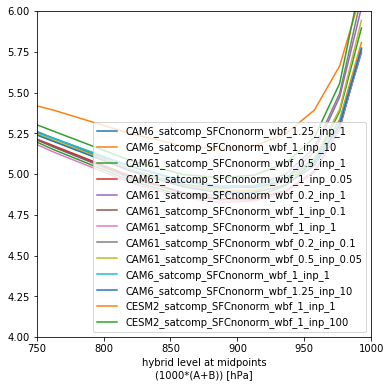

In [203]:
fig,axs = plt.subplots(1,1,figsize=(6,6))

for i in dtas_ndjfma:
    dtas_ndjfma[i].plot(label=i)
    
axs.set_xlim(750,1000)
axs.set_ylim(4,6)

plt.legend()

### Calculate model feedbacks

In [32]:
fb_dir

'feedbacks_soden/mod_by_me/output_jonahks/'

In [33]:
cases2 = os.listdir(fb_dir)
case_dict2 = {} # Cases are keys, feedback dictionaries are values
case_dict2_aprp = {} # Cases are keys, feedback dictionaries are values

for _case in cases2:
    if "SFCnonorm" in _case:
        print(_case)
        case_dict2[_case] = org_feedbacks_case(_case)
#         case_dict2_aprp[_case] = get_APRP(_case)        # didn't calculate APRP for new simulations

CAM61_satcomp_SFCnonorm_wbf_0.5_inp_1
CAM61_satcomp_SFCnonorm_wbf_1_inp_0.1
CAM61_satcomp_SFCnonorm_wbf_0.2_inp_1
CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10
CAM61_satcomp_SFCnonorm_wbf_1_inp_1
CAM6_satcomp_SFCnonorm_wbf_1_inp_10
CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1
CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05
CESM2_satcomp_SFCnonorm_wbf_1_inp_100
CESM2_satcomp_SFCnonorm_wbf_1_inp_1
CAM61_satcomp_SFCnonorm_wbf_1_inp_0.05
CAM6_satcomp_SFCnonorm_wbf_1.25_inp_1
CAM6_satcomp_SFCnonorm_wbf_1_inp_1


In [34]:
desired_order_list = ['CAM6_satcomp_SFCnonorm_wbf_1_inp_10',
                      'CAM6_satcomp_SFCnonorm_wbf_1.25_inp_1',
                      'CAM61_satcomp_SFCnonorm_wbf_0.5_inp_1',
                      'CAM61_satcomp_SFCnonorm_wbf_1_inp_0.05',
                      'CAM61_satcomp_SFCnonorm_wbf_0.2_inp_1',
                      'CAM61_satcomp_SFCnonorm_wbf_1_inp_0.1',
                      'CAM6_satcomp_SFCnonorm_wbf_1_inp_1',
                      'CESM2_satcomp_SFCnonorm_wbf_1_inp_1',
                      'CAM61_satcomp_SFCnonorm_wbf_1_inp_1',
                      'CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10',
                      'CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05',
                      'CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1',
                      'CESM2_satcomp_SFCnonorm_wbf_1_inp_100',
                      ]

desired_order_list_fitted = [
                      'CAM6_satcomp_SFCnonorm_wbf_1_inp_1',
                      'CESM2_satcomp_SFCnonorm_wbf_1_inp_1',
                      'CAM61_satcomp_SFCnonorm_wbf_1_inp_1',
                      'CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10',
                      'CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05',
                      'CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1',
                      'CESM2_satcomp_SFCnonorm_wbf_1_inp_100',
                      ]

case_dict2b = {k: case_dict2[k] for k in desired_order_list}
case_dict2c = {k: case_dict2[k] for k in desired_order_list_fitted}
# case_dict2b_aprp = {k: case_dict2_aprp[k] for k in desired_order_list} # comment out APRP stuff

### Weights feedbacks by Arctic surface temperature increase

In [35]:
label_dict

{'CAM6_satcomp_SFCnonorm_wbf_1.25_inp_1': 'CAM6-Oslo (WBF:1.25 INP:1)',
 'CAM6_satcomp_SFCnonorm_wbf_1_inp_10': 'CAM6-Oslo (WBF:1 INP:10)',
 'CAM61_satcomp_SFCnonorm_wbf_0.5_inp_1': 'CAM6-OsloIce (WBF:0.5 INP:1)',
 'CAM61_satcomp_SFCnonorm_wbf_1_inp_0.05': 'CAM6-OsloIce (WBF:1 INP:0.05)',
 'CAM61_satcomp_SFCnonorm_wbf_0.2_inp_1': 'CAM6-OsloIce (WBF:0.2 INP:1)',
 'CAM61_satcomp_SFCnonorm_wbf_1_inp_0.1': 'CAM6-OsloIce (WBF:1 INP:0.1)',
 'CAM6_satcomp_SFCnonorm_wbf_1_inp_1': 'CAM6-Oslo',
 'CESM2_satcomp_SFCnonorm_wbf_1_inp_1': 'CAM6',
 'CAM61_satcomp_SFCnonorm_wbf_1_inp_1': 'CAM6-OsloIce',
 'CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10': 'CAM6-Oslo Fit 1',
 'CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05': 'CAM6-OsloIce Fit 2',
 'CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1': 'CAM6-OsloIce Fit 3',
 'CESM2_satcomp_SFCnonorm_wbf_1_inp_100': 'CAM6 Fit 4'}

In [93]:
out2 = weight_feedbacks(case_dict2b,weights=ts_dict,labels=label_dict)
out2c = weight_feedbacks(case_dict2c,weights=ts_dict,labels=label_dict_fitted)

CAM6_satcomp_SFCnonorm_wbf_1.25_inp_1
CAM6_satcomp_SFCnonorm_wbf_1_inp_10
CAM61_satcomp_SFCnonorm_wbf_0.5_inp_1
CAM61_satcomp_SFCnonorm_wbf_1_inp_0.05
CAM61_satcomp_SFCnonorm_wbf_0.2_inp_1
CAM61_satcomp_SFCnonorm_wbf_1_inp_0.1
CAM6_satcomp_SFCnonorm_wbf_1_inp_1
CESM2_satcomp_SFCnonorm_wbf_1_inp_1
CAM61_satcomp_SFCnonorm_wbf_1_inp_1
CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10
CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05
CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1
CESM2_satcomp_SFCnonorm_wbf_1_inp_100
CAM6_satcomp_SFCnonorm_wbf_1_inp_1
CESM2_satcomp_SFCnonorm_wbf_1_inp_1
CAM61_satcomp_SFCnonorm_wbf_1_inp_1
CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10
CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05
CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1
CESM2_satcomp_SFCnonorm_wbf_1_inp_100


###  Create Arctic-normalized APRP SW cloud fb variable

In [31]:
# Create Arctic-normalized APRP SW cloud fb variable
APRP_SW_FB = []

for i in case_dict2b_aprp:
    dTS_arc = ts_dict[i]
    _case = case_dict2b_aprp[i]
    
    _case['SWfeedback_cloud_AN'] = _case['SWfeedback_cloud_f'] / dTS_arc
    _ds = _case['SWfeedback_cloud_AN']
    
    weights = _case['cell_weight']
    mask = np.bitwise_or(_ds['lat']<=66,_ds['lat']>82)
    
    _arc_val = masked_average(_ds,dim=['lat','lon'],weights=weights,mask=mask)
    APRP_SW_FB.append(_arc_val)
    
out2['APRP_SWfb'] = APRP_SW_FB

NameError: name 'case_dict2b_aprp' is not defined

## Correlate and plot LW feedback against the april cloud bias

In [32]:
labels = list(label_dict.values())

__I think that these functions are old.__

In [37]:
def plot_correlation(month,fb_vars,ax=None,totm=1,legend=False,otherx=None):
    '''
    all_data just uses the total cloud processed data (only uses CLDTOT obs too)
    can only regress against feedback variable
    '''
    month_names = {'1':'January','2':'February','3':'March',
                  '4':'April','5':'May','6':'June',
                  '7':'July','8':'August','9':'September',
                  '10':'October','11':'November','12':'December'}
    month_name = month_names[str(month)]

    months_temp = np.arange(month,month+totm)
    months = np.where(months_temp > 12, months_temp % 12, months_temp)

    # Takes nested dictionaries with first layer indexed by case and second layer indexed by month integer.
    _,ex_data = get_month(1,allmonth_clouddict) # second output is a list object
    all_data = np.zeros(ex_data.shape)

    for i in months:
        _,data = get_month(i,allmonth_clouddict)
        all_data += data    
    all_data = all_data / totm # mean cloud cover

    # Do correlation
    y = np.zeros(ex_data.shape)
    for i in fb_vars:
        y += np.array(out2[i])
    y = np.array(y)    
    
    x = np.array(all_data) - float(arc_mean.sel(month=months).mean('month')) # subtract the obs to get bias. needs to handle totm

    _slope, _intercept, _r_value, _p_value, _std_err =stats.linregress(x,y)
        
#     model = LinearRegression()
#     model.fit(x.reshape(-1,1), y.reshape(-1,1))
#     y_new = model.predict(x_new[:, np.newaxis])
#     y_pred = model.predict(x.reshape(-1,1))

    x_new = np.linspace(min(x), max(x), 100)
    y_pred = (x*_slope + _intercept).squeeze()
    y_new = (x_new*_slope + _intercept).squeeze()
    
    N=len(x) # data point count (could be len(mon['time.year']) <-- same)

    dof=N-2
    tcrit=stats.t.ppf(0.975,dof)  ## two-sided 95%
    t=_r_value*np.sqrt(N-2)/np.sqrt((1-_r_value*_r_value))

    statsig_percent=(1-_p_value)*100
    statsig = str(np.round(statsig_percent,2))
    if np.abs(t)>tcrit:
        statsig += "*"

    categories = np.array([0, 1, 2, 3, 4, 5, 6, 7])
    colormap = np.array(sns.color_palette('colorblind'))
    
    # Plot correlation
    if not ax:
        fig,ax = plt.subplots(nrows=1,ncols=1)#,sharey='row')
        ax.set_ylabel('LW Cloud Feedback (Wm$^{-2}$K$^{-1}$)',fontsize=14)
        ax.set_xlabel('Modelled Present-day Cloud Fraction Bias - %s (%%)' % month_name,fontsize=14)
        fig.text(0.65, 0.74, '$R^2 = %.2f$' % (_r_value**2), va='bottom', 
                 ha='center', rotation='horizontal',rotation_mode='anchor', fontsize=18)
    else:
#         ax.set_ylabel('LW Cloud Feedback (Wm$^{-2}$K$^{-1}$)',fontsize=14)
        ax.set_xlabel('%s - $R^2 = %.2f, p= %.2f$' % (month_name,_r_value**2,_p_value), fontsize=12)

    scatter = ax.scatter(x, y, c=colormap[categories],marker='o')
#     ax.legend(labels=labels)    
    ax.plot(x_new,y_new,c='grey',linestyle='dotted')
    
    if legend:
        labels = []; lines = [] #Plot invisible bar graph but have the legends specified
        for _name,_color in zip(label_names,colormap[categories]):
            labels.append(_name)
            _line = ax.scatter(1,1,color=_color)
            lines.append(_line)
        return lines

    return _r_value**2,statsig
#         lgd = ax.legend(labels=labels,handles=lines,loc=(0.9, 0.40),fontsize=12)
    
#     print(scatter)
#     legend1 = ax.legend(*scatter.legend_elements(),
#                     loc="lower left", title="Classes")
#     ax.add_artist(legend1)
    
#     return scatter

In [38]:
def get_month_arb(month_index,data_dict):
    '''
    This code is bad and I should feel bad. Requires a dictionary with keys as 1d dataarrays indexed by month.
    '''
    
    out_dict = {}
    for i in data_dict:
        _da = data_dict[i]
        out_dict[i] = _da.sel(month=month_index).values
        
    out_list = np.array(list(out_dict.values())).flatten() # list of length #models
    
    return out_dict,out_list

In [248]:
def plot_correlation_arb2(month,x,y,ax=None,totm=1,legend=False,labels=None,colors=None,linestyle='dotted',alpha=1.0,color='black'):
    '''
    'month' is the start month, 'totm' is the total number of months
    vertical and horizontal are the variables to correlate (horizontal should be model output)
    horizontal is in the form of nested dictionaries with first layer indexed by case and second layer indexed by month integer
    '''    
    
    # Get the months right
    month_names = {'1':'January','2':'February','3':'March',
                  '4':'April','5':'May','6':'June',
                  '7':'July','8':'August','9':'September',
                  '10':'October','11':'November','12':'December'}
    month_name = month_names[str(month)]
    
    # Call stats wrapper
    _slope, _intercept, _r_value, _p_value, _std_err =stats.linregress(x,y)
        
    x_new = np.linspace(min(x), max(x), 100)
    y_pred = (x*_slope + _intercept).squeeze()
    y_new = (x_new*_slope + _intercept).squeeze()
    
    N=len(x) # data point count (could be len(mon['time.year']) <-- same)

    dof=N-2
    tcrit=stats.t.ppf(0.975,dof)  ## two-sided 95%
    t=_r_value*np.sqrt(N-2)/np.sqrt((1-_r_value*_r_value))

    statsig_percent=(1-_p_value)*100
    statsig = str(np.round(statsig_percent,2))
    if np.abs(t)>tcrit:
        statsig += "*"

#     categories = np.array([0, 1, 2, 3, 4, 5, 6, 7])
    categories = np.arange(0,len(x),1)
    if colors:
        colormap = colors
    else:
        colormap = np.array(sns.color_palette('colorblind'))
        
    # Plot correlation
    if not ax:
        fig,ax = plt.subplots(nrows=1,ncols=1)#,sharey='row')
        ax.set_ylabel('LW Cloud Feedback (Wm$^{-2}$K$^{-1}$)',fontsize=14)
        ax.set_xlabel('Modelled Present-day Cloud Fraction Bias - %s (%%)' % month_name,fontsize=14)
        fig.text(0.65, 0.74, '$R^2 = %.2f$' % (_r_value**2), va='bottom', 
                 ha='center', rotation='horizontal',rotation_mode='anchor', fontsize=18)
    else:
#         ax.set_ylabel('LW Cloud Feedback (Wm$^{-2}$K$^{-1}$)',fontsize=14)
        ax.set_xlabel('%s - $R^2 = %.2f, p= %.3f$' % (month_name,_r_value**2,_p_value), fontsize=12)

#     scatter = ax.scatter(x, y, c=colormap[categories],marker='o')
    scatter = ax.scatter(x, y, c=colormap,marker='o')
#     ax.legend(labels=labels)    
    ax.plot(x_new,y_new,c='grey',linestyle=linestyle,alpha=alpha,color=color)
    
    if legend:
        blank_fig,blank_axs = plt.subplots(1,1)
        _labels = []; _lines = [] #Plot invisible bar graph but have the legends specified
        for _name,_color in zip(labels,colormap):
            _labels.append(_name)
#             _line = ax.scatter(1,1,color=_color)
            _line = blank_axs.scatter(1,1,color=_color)
            _lines.append(_line)
        plt.close(blank_fig)
        return _r_value**2,_p_value,_lines,_labels

    return _r_value**2,_p_value    
#     return _r_value**2,statsig

In [40]:
def select_month_range(month_index,data_dict,totm=1):
    '''
    Select the month by index and the following totm - 1 months
    '''
    
    # Get the months right
    month_names = {'1':'January','2':'February','3':'March',
                  '4':'April','5':'May','6':'June',
                  '7':'July','8':'August','9':'September',
                  '10':'October','11':'November','12':'December'}
    month_name = month_names[str(month_index)]

    months_temp = np.arange(month_index,month_index+totm)
    months = np.where(months_temp > 12, months_temp % 12, months_temp)

    # Get shape right.
#     _,ex_data = get_month(1,horizontal)
    _,ex_data = get_month_arb(1,data_dict)
    all_data = np.zeros(ex_data.shape)

    for i in months:
#         _,data = get_month(i,horizontal)
        _,data = get_month_arb(i,data_dict)
        all_data += data    
    all_data = all_data / totm # mean cloud cover

    return all_data
    # Do correlation
#     x = np.array(all_data) #- float(arc_mean.sel(month=months).mean('month')) # subtract the obs to get bias. needs to handle totm
#     y = np.array(vertical)

### Plot monthly LW correlations

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.p

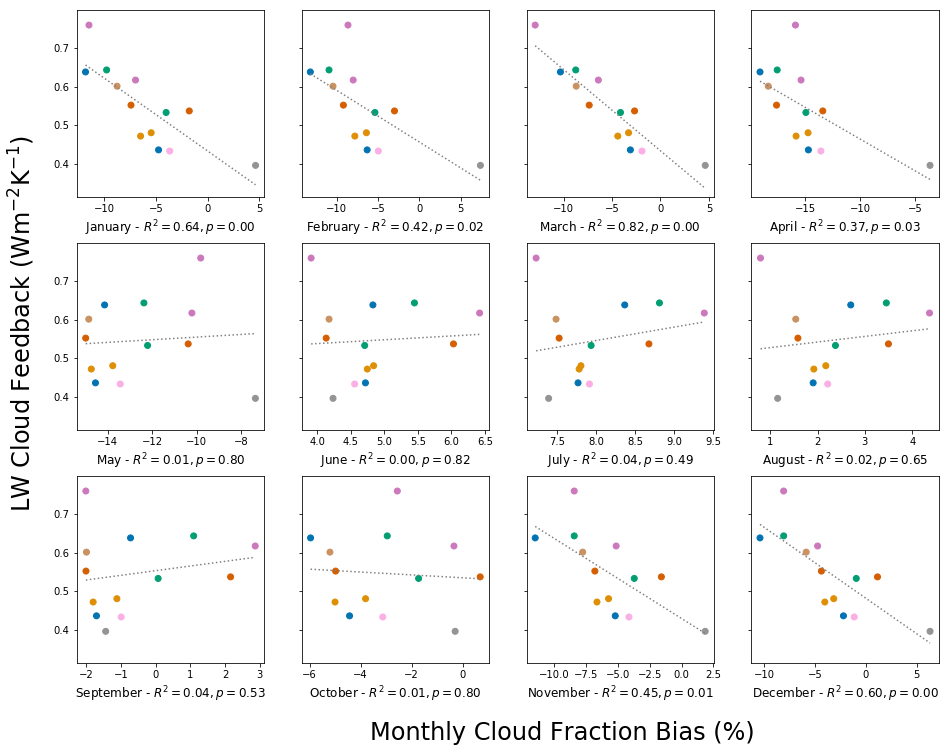

In [41]:
fig,axs = plt.subplots(nrows=3,ncols=4,figsize=(18,12),sharey=True)
fig.subplots_adjust(hspace=0.25)

# Subplot-wide axis labelling
fig.text(0.50, 0.030, 'Monthly Cloud Fraction Bias (%)', 
         va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.09, 0.30, 'LW Cloud Feedback (Wm$^{-2}$K$^{-1}$)',
         rotation='vertical', rotation_mode='anchor', fontsize=24)

for i,ax in enumerate(axs.flat):
    out = plot_correlation(i+1,['cloudlw_fb'],ax)

# lgd = fig.legend(labels=labels,handles=lines,loc=(0.80, 0.40),fontsize=18)

fig.subplots_adjust(right=0.79)

In [97]:
to_png(fig,'month_LW_corrs_p')

### Plot monthly LW correlations against total cloud amount change

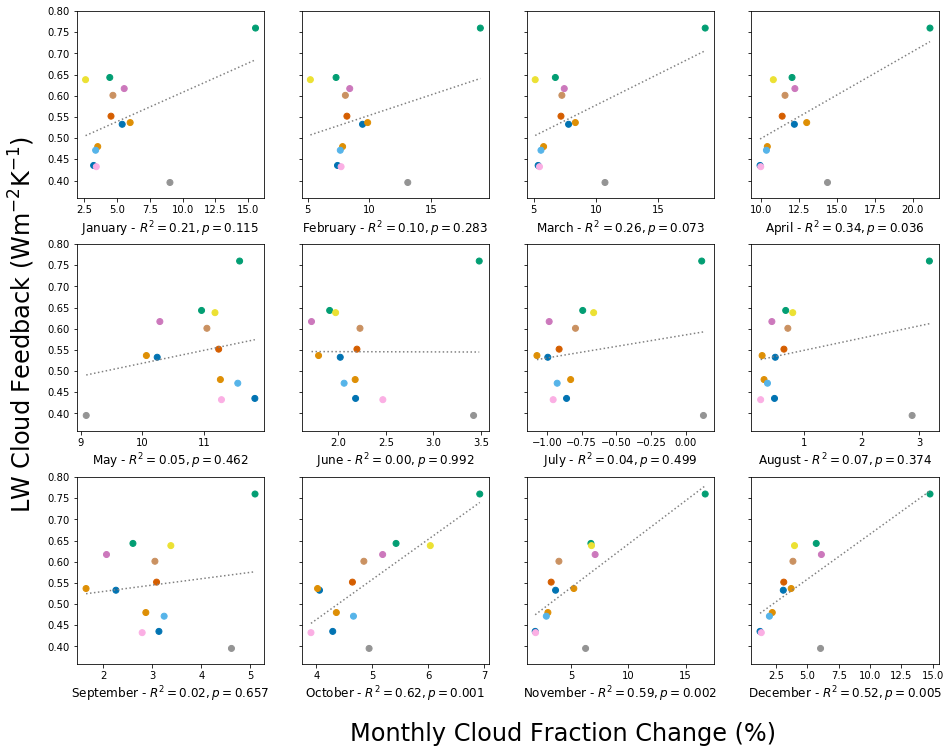

In [44]:
fig,axs = plt.subplots(nrows=3,ncols=4,figsize=(18,12),sharey=True)
fig.subplots_adjust(hspace=0.25)

# Subplot-wide axis labelling
fig.text(0.50, 0.030, 'Monthly Cloud Fraction Change (%)', 
         va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.09, 0.30, 'LW Cloud Feedback (Wm$^{-2}$K$^{-1}$)',
         rotation='vertical', rotation_mode='anchor', fontsize=24)

for i,ax in enumerate(axs.flat):
    x = select_month_range(i+1,dCt_dict_monthly,totm=1)
    
    out = plot_correlation_arb2(i+1,x,out2['cloudlw_fb'],ax)

# lgd = fig.legend(labels=labels,handles=lines,loc=(0.80, 0.40),fontsize=18)

fig.subplots_adjust(right=0.79)

In [60]:
to_png(fig,'month_LW_corrs_cloudchange')

### Plot monthly LW correlations against low cloud amount change

In [45]:
low_cloud_diff_arcavg = {}

for i in low_cloud_diff:
    print(i)
    _ds = add_weights(low_cloud_diff[i])
    
    mask = _ds['lat'] < 66
    arc_mean = masked_average(_ds,mask=mask,weights=_ds['cell_weight'],dim=['lat','lon'])
    
    low_cloud_diff_arcavg[i] = arc_mean

CAM6_satcomp_SFCnonorm_wbf_1.25_inp_1
CAM6_satcomp_SFCnonorm_wbf_1_inp_10
CAM61_satcomp_SFCnonorm_wbf_0.5_inp_1
CAM61_satcomp_SFCnonorm_wbf_1_inp_0.05
CAM61_satcomp_SFCnonorm_wbf_0.2_inp_1
CAM61_satcomp_SFCnonorm_wbf_1_inp_0.1
CAM6_satcomp_SFCnonorm_wbf_1_inp_1
CESM2_satcomp_SFCnonorm_wbf_1_inp_1
CAM61_satcomp_SFCnonorm_wbf_1_inp_1
CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10
CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05
CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1
CESM2_satcomp_SFCnonorm_wbf_1_inp_100


In [46]:
lowliq_cloud_diff_arcavg = {}

for i in lowliq_cloud_diff:
    print(i)
    _ds = add_weights(lowliq_cloud_diff[i])
    
    mask = _ds['lat'] < 66
    arc_mean = masked_average(_ds,mask=mask,weights=_ds['cell_weight'],dim=['lat','lon'])
    
    lowliq_cloud_diff_arcavg[i] = arc_mean

CAM6_satcomp_SFCnonorm_wbf_1.25_inp_1
CAM6_satcomp_SFCnonorm_wbf_1_inp_10
CAM61_satcomp_SFCnonorm_wbf_0.5_inp_1
CAM61_satcomp_SFCnonorm_wbf_1_inp_0.05
CAM61_satcomp_SFCnonorm_wbf_0.2_inp_1
CAM61_satcomp_SFCnonorm_wbf_1_inp_0.1
CAM6_satcomp_SFCnonorm_wbf_1_inp_1
CESM2_satcomp_SFCnonorm_wbf_1_inp_1
CAM61_satcomp_SFCnonorm_wbf_1_inp_1
CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10
CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05
CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1
CESM2_satcomp_SFCnonorm_wbf_1_inp_100


In [119]:
axs.flat

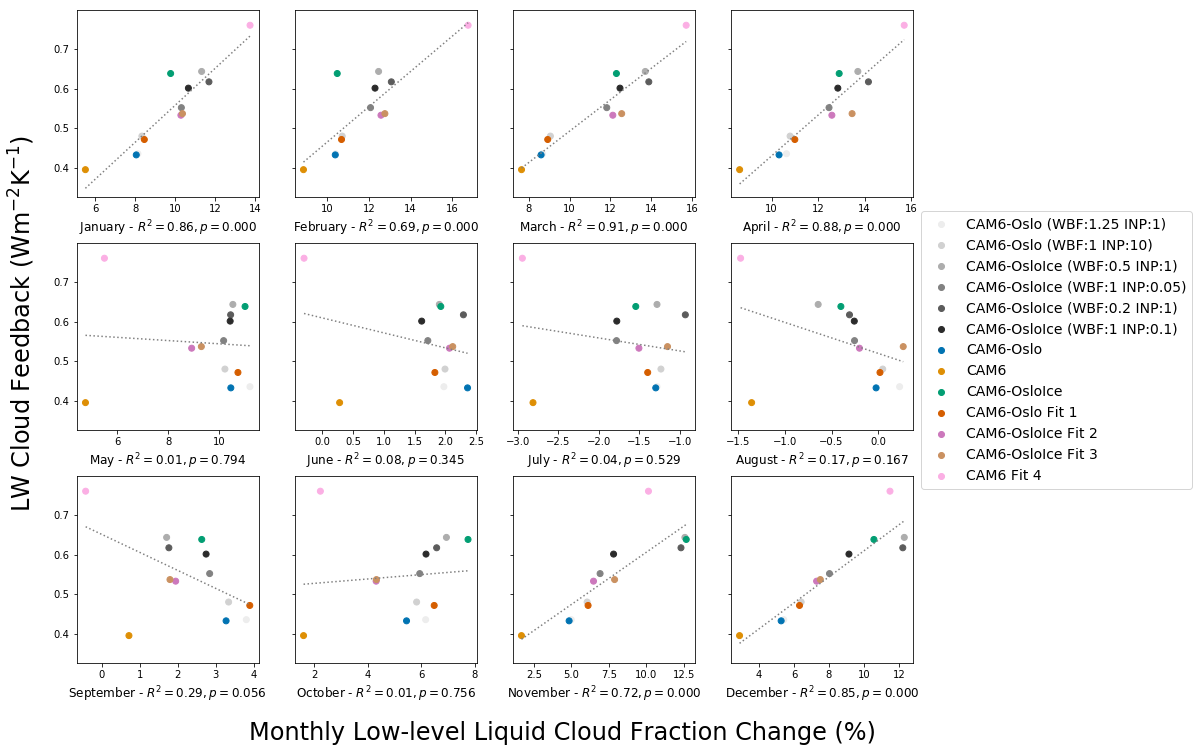

In [137]:
fig,axs = plt.subplots(nrows=3,ncols=4,figsize=(18,12),sharey=True)
fig.subplots_adjust(hspace=0.25)

axs = axs.flat

# Subplot-wide axis labelling
fig.text(0.50, 0.030, 'Monthly Low-level Liquid Cloud Fraction Change (%)', 
         va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.09, 0.30, 'LW Cloud Feedback (Wm$^{-2}$K$^{-1}$)',
         rotation='vertical', rotation_mode='anchor', fontsize=24)

for i,ax in enumerate(axs):
    x = select_month_range(i+1,lowliq_cloud_diff_arcavg,totm=1)
#     x = select_month_range(i+1,low_cloud_diff_arcavg,totm=1)
    
    _rval,_pval,_lines,_labels = plot_correlation_arb2(i+1,x,out2['cloudlw_fb'],ax,colors=corr_palette,legend=True,labels=list(label_dict.values()))

# lgd = fig.legend(labels=labels,handles=lines,loc=(0.80, 0.40),fontsize=18)


# axs[-1].legend(handles=_lines,labels=_labels,loc=(0.65, 0.03))
fig.legend(handles=_lines,labels=_labels,loc=(0.772, 0.35),fontsize=14)

fig.subplots_adjust(right=0.77)


In [138]:
to_png(fig,'month_LW_corrs_lowliqcloudchange')

### Plot LW correlations May - October and November - April cloud amount change

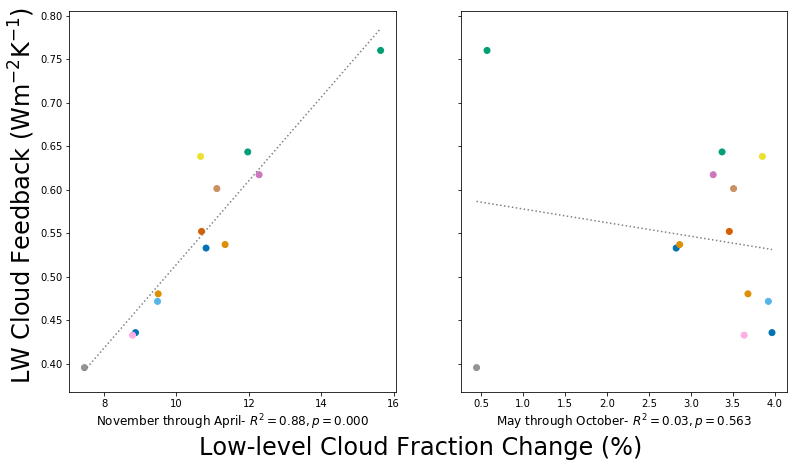

In [48]:
fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(15,7),sharey=True)
fig.subplots_adjust(hspace=0.25)

# Subplot-wide axis labelling
fig.text(0.45, -0.01, 'Low-level Cloud Fraction Change (%)', 
         va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.09, 0.14, 'LW Cloud Feedback (Wm$^{-2}$K$^{-1}$)',
         rotation='vertical', rotation_mode='anchor', fontsize=24)

start_months = [11,5]

for i,ax in zip(start_months,axs.flat):
    x = select_month_range(i,low_cloud_diff_arcavg,totm=6)
#     x = select_month_range(i,dCt_dict_monthly,totm=6)
    
    out = plot_correlation_arb2(i,x,out2['cloudlw_fb'],ax)

axs[0].set_xlabel('November through April' + axs[0].get_xlabel()[-24:])
axs[1].set_xlabel('May through October' + axs[1].get_xlabel()[-24:])
    
fig.subplots_adjust(right=0.79)

### Plot monthly LW correlations against low cloud amount in present-day

In [49]:
low_cloud_init_monthly = {}

for i in low_cloud_init:
    print(i)
    _ds = add_weights(low_cloud_init[i])
    
    mask = _ds['lat'] < 66
    arc_mean = masked_average(_ds,mask=mask,weights=_ds['cell_weight'],dim=['lat','lon'])
    
    low_cloud_init_monthly[i] = arc_mean

CAM6_satcomp_SFCnonorm_wbf_1.25_inp_1
CAM6_satcomp_SFCnonorm_wbf_1_inp_10
CAM61_satcomp_SFCnonorm_wbf_0.5_inp_1
CAM61_satcomp_SFCnonorm_wbf_1_inp_0.05
CAM61_satcomp_SFCnonorm_wbf_0.2_inp_1
CAM61_satcomp_SFCnonorm_wbf_1_inp_0.1
CAM6_satcomp_SFCnonorm_wbf_1_inp_1
CESM2_satcomp_SFCnonorm_wbf_1_inp_1
CAM61_satcomp_SFCnonorm_wbf_1_inp_1
CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10
CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05
CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1
CESM2_satcomp_SFCnonorm_wbf_1_inp_100


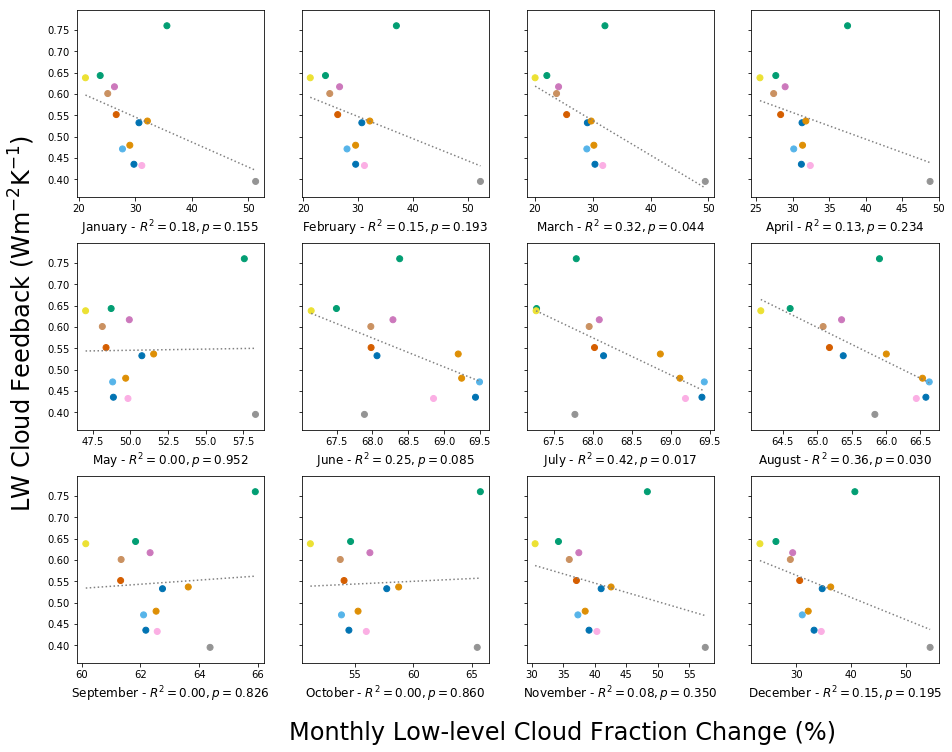

In [50]:
fig,axs = plt.subplots(nrows=3,ncols=4,figsize=(18,12),sharey=True)
fig.subplots_adjust(hspace=0.25)

# Subplot-wide axis labelling
fig.text(0.50, 0.030, 'Monthly Low-level Cloud Fraction Change (%)', 
         va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.09, 0.30, 'LW Cloud Feedback (Wm$^{-2}$K$^{-1}$)',
         rotation='vertical', rotation_mode='anchor', fontsize=24)

for i,ax in enumerate(axs.flat):
    x = select_month_range(i+1,low_cloud_init_monthly,totm=1)
    
    out = plot_correlation_arb2(i+1,x,out2['cloudlw_fb'],ax)

# lgd = fig.legend(labels=labels,handles=lines,loc=(0.80, 0.40),fontsize=18)

fig.subplots_adjust(right=0.79)

In [60]:
to_png(fig,'month_LW_corrs_cloudchange')

### Plot LW correlations May - October and November - April cloud amount change

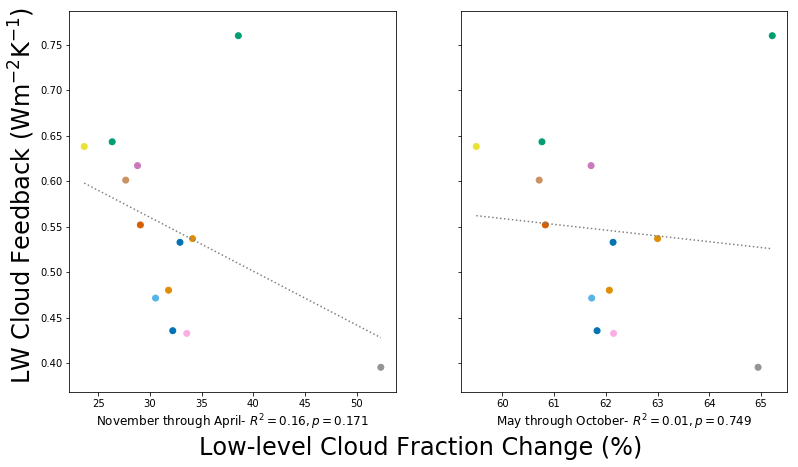

In [51]:
fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(15,7),sharey=True)
fig.subplots_adjust(hspace=0.25)

# Subplot-wide axis labelling
fig.text(0.45, -0.01, 'Low-level Cloud Fraction Change (%)', 
         va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.09, 0.14, 'LW Cloud Feedback (Wm$^{-2}$K$^{-1}$)',
         rotation='vertical', rotation_mode='anchor', fontsize=24)

start_months = [11,5]

for i,ax in zip(start_months,axs.flat):
    x = select_month_range(i,low_cloud_init_monthly,totm=6)
#     x = select_month_range(i,dCt_dict_monthly,totm=6)
    
    out = plot_correlation_arb2(i,x,out2['cloudlw_fb'],ax)

axs[0].set_xlabel('November through April' + axs[0].get_xlabel()[-24:])
axs[1].set_xlabel('May through October' + axs[1].get_xlabel()[-24:])
    
fig.subplots_adjust(right=0.79)

### Plot correlation between temperature change and feedback

In [43]:
# Sum of feedbacks
lambda_dict = {'CAM61_satcomp_SFCnonorm_wbf_1_inp_1':0.96,
              'CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1':0.98,
              'CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05':0.94,
              'CAM6_satcomp_SFCnonorm_wbf_1_inp_1':0.93,
              'CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10':0.96,
              'CESM2_satcomp_SFCnonorm_wbf_1_inp_1':0.88,
              'CESM2_satcomp_SFCnonorm_wbf_1_inp_100':1.07,
              }

In [56]:
dts = []
lambdas = []

for i in label_dict:
    dts.append(ts_dict[i])
    lambdas.append(lambda_dict[i])

dts = np.array(dts)
lambdas = np.array(lambdas)

(0.2719471769965785, '77.0')

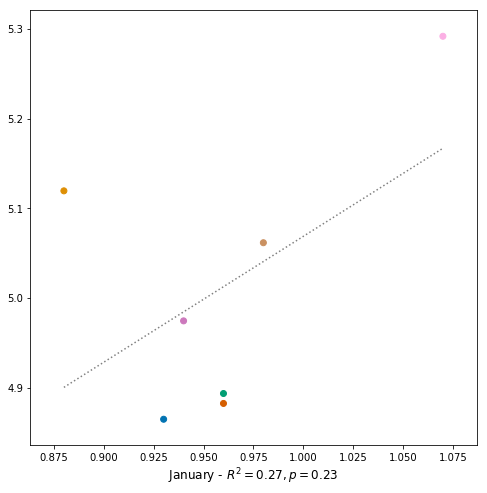

In [57]:
# The sum of the feedbacks is not correlated with the temperature change even though the forcing is identical, 
# indicates that there is uneven external forcing from outside of the Arctic

fig,ax = plt.subplots(1,1,figsize=(8,8))

plot_correlation_arb2(1,lambdas,dts,ax)

### Plot 3-monthly LW correlations

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.p

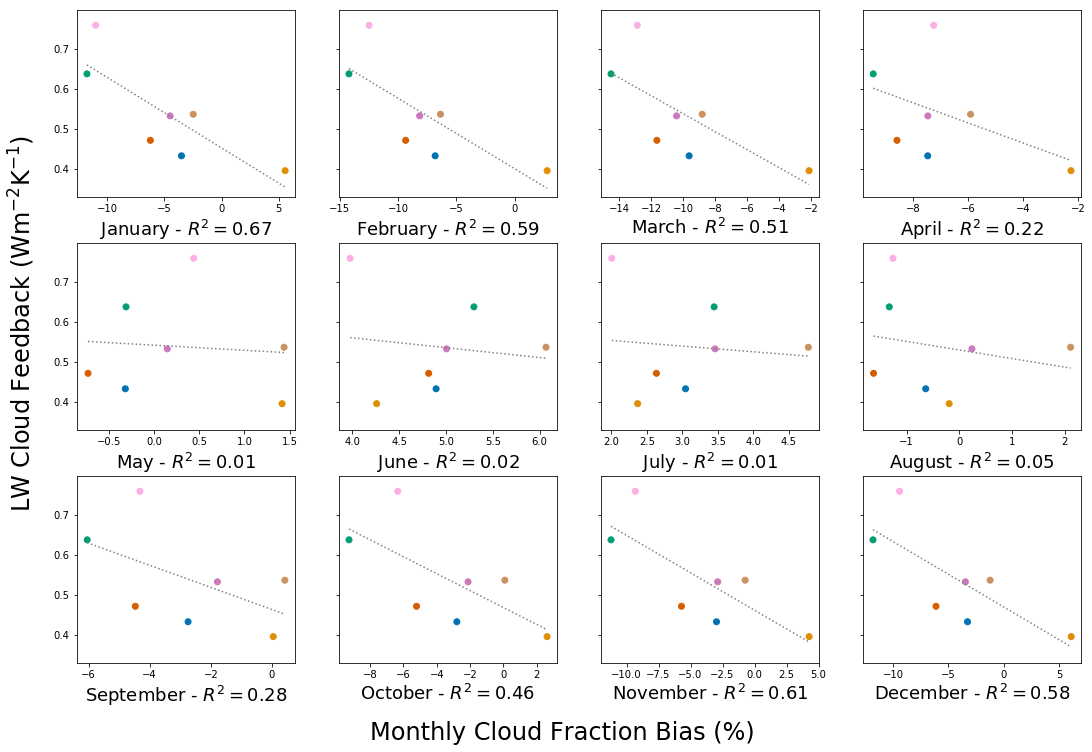

In [28]:
fig,axs = plt.subplots(nrows=3,ncols=4,figsize=(18,12),sharey=True)
fig.subplots_adjust(hspace=0.25)

# Subplot-wide axis labelling
fig.text(0.50, 0.030, 'Monthly Cloud Fraction Bias (%)', 
         va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.09, 0.30, 'LW Cloud Feedback (Wm$^{-2}$K$^{-1}$)',
         rotation='vertical', rotation_mode='anchor', fontsize=24)

for i,ax in enumerate(axs.flat):
    plot_correlation(i+1,['cloudlw_fb'],ax,totm=3)

### Plot monthly SW feedback correlations

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.p

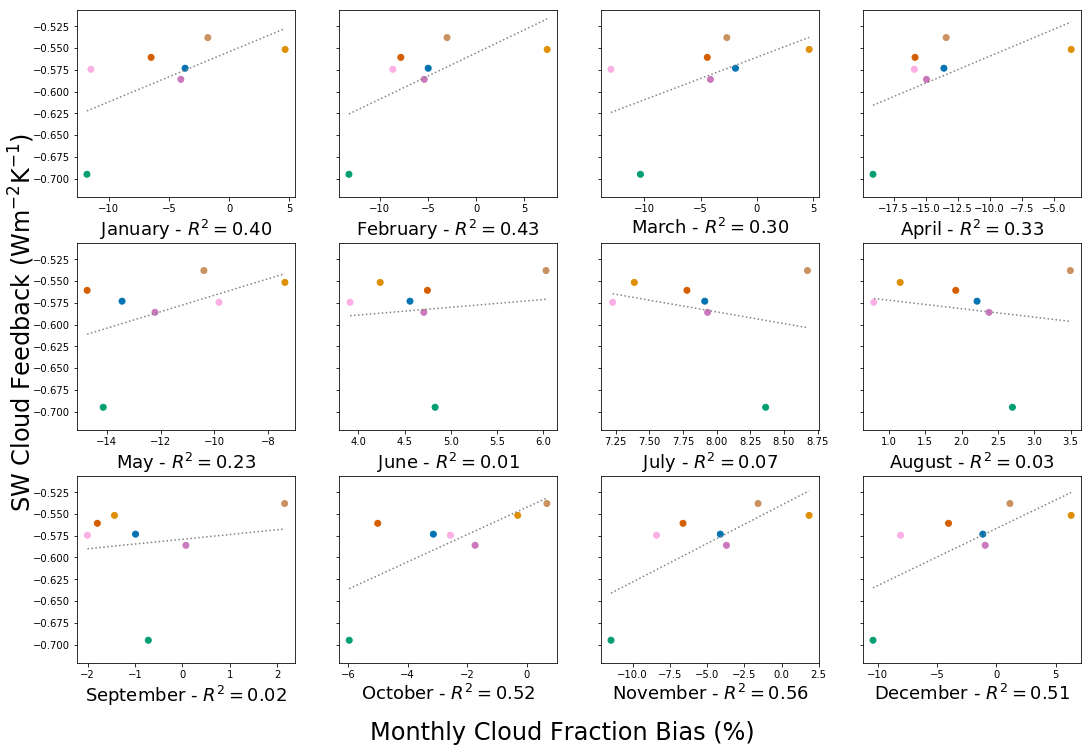

In [29]:
fig,axs = plt.subplots(nrows=3,ncols=4,figsize=(18,12),sharey=True)
fig.subplots_adjust(hspace=0.25)

# Subplot-wide axis labelling
fig.text(0.50, 0.030, 'Monthly Cloud Fraction Bias (%)', 
         va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.09, 0.30, 'SW Cloud Feedback (Wm$^{-2}$K$^{-1}$)',
         rotation='vertical', rotation_mode='anchor', fontsize=24)

for i,ax in enumerate(axs.flat):
    plot_correlation(i+1,['cloudsw_fb'],ax)

### Plot 3-monthly SW feedback correlations

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.p

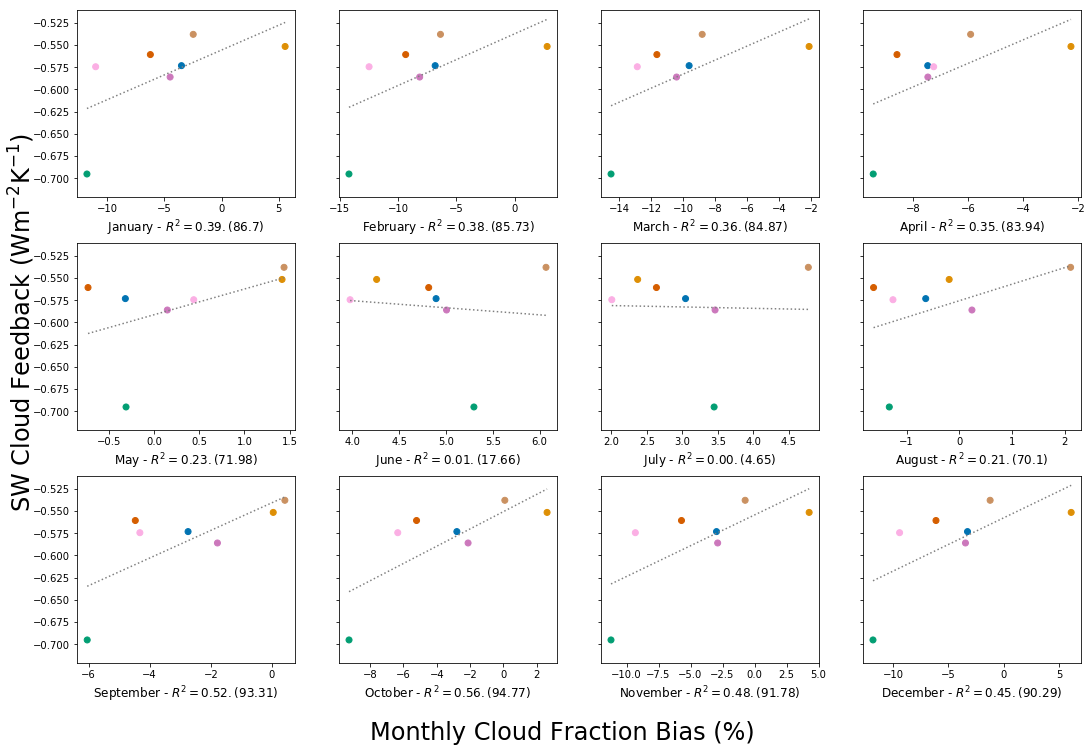

In [68]:
fig,axs = plt.subplots(nrows=3,ncols=4,figsize=(18,12),sharey=True)
fig.subplots_adjust(hspace=0.25)

# Subplot-wide axis labelling
fig.text(0.50, 0.030, 'Monthly Cloud Fraction Bias (%)', 
         va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.09, 0.30, 'SW Cloud Feedback (Wm$^{-2}$K$^{-1}$)',
         rotation='vertical', rotation_mode='anchor', fontsize=24)

for i,ax in enumerate(axs.flat):
    plot_correlation(i+1,['cloudsw_fb'],ax,totm=3)

### Plot monthly net cloud feedback correlations

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.p

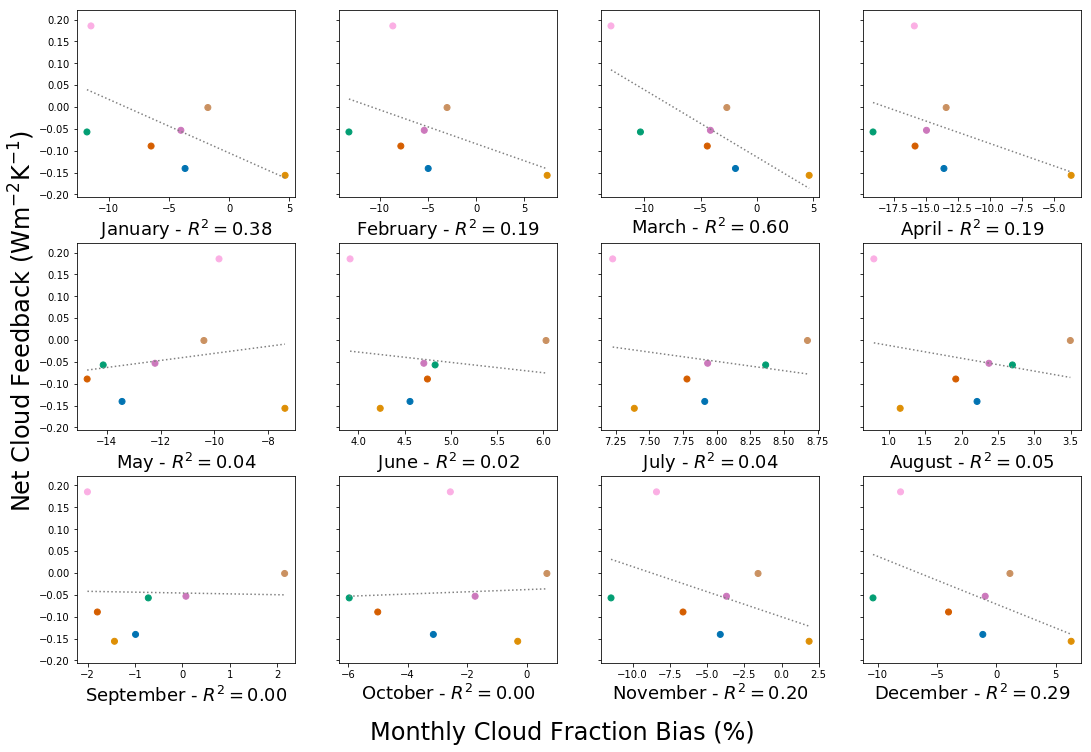

In [31]:
fig,axs = plt.subplots(nrows=3,ncols=4,figsize=(18,12),sharey=True)
fig.subplots_adjust(hspace=0.25)

# Subplot-wide axis labelling
fig.text(0.50, 0.030, 'Monthly Cloud Fraction Bias (%)', 
         va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.09, 0.30, 'Net Cloud Feedback (Wm$^{-2}$K$^{-1}$)',
         rotation='vertical', rotation_mode='anchor', fontsize=24)

for i,ax in enumerate(axs.flat):
    plot_correlation(i+1,['cloudsw_fb','cloudlw_fb'],ax)

### Plot 3-monthly net cloud feedback correlations

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.p

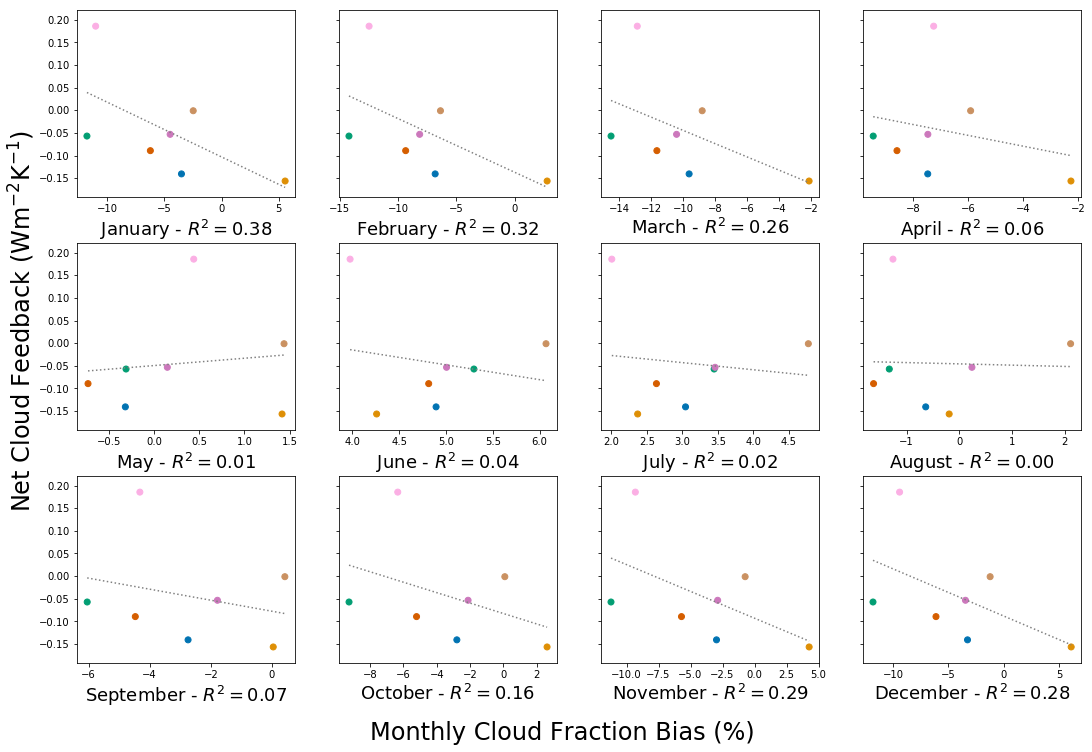

In [32]:
fig,axs = plt.subplots(nrows=3,ncols=4,figsize=(18,12),sharey=True)
fig.subplots_adjust(hspace=0.25)

# Subplot-wide axis labelling
fig.text(0.50, 0.030, 'Monthly Cloud Fraction Bias (%)', 
         va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.09, 0.30, 'Net Cloud Feedback (Wm$^{-2}$K$^{-1}$)',
         rotation='vertical', rotation_mode='anchor', fontsize=24)

for i,ax in enumerate(axs.flat):
    plot_correlation(i+1,['cloudsw_fb','cloudlw_fb'],ax,totm=3)

## Plot the stuff

In [66]:
# Read in SLF curves from the other runs (I saved this to my lab notebook)
slf_completeness = {
    'CAM6_satcomp_SFCnonorm_wbf_1.25_inp_1': np.array([0.04552452, 0.27212925, 0.47064839, 0.71164886, 0.87986859,
        0.95033369, 0.98145678, 0.9976638 , 0.99963227]),
    'CAM6_satcomp_SFCnonorm_wbf_1_inp_10': np.array([0.05385359, 0.2770469 , 0.48097249, 0.73169693, 0.88559639,
        0.95361536, 0.98197899, 0.99753196, 0.99965311]),
    'CAM61_satcomp_SFCnonorm_wbf_0.5_inp_1': np.array([0.04258131, 0.05242366, 0.11888936, 0.28951538, 0.76257104,
        0.92401048, 0.96827091, 0.99490383, 0.99955984]),
    'CAM61_satcomp_SFCnonorm_wbf_1_inp_0.05': np.array([0.03907804, 0.13873691, 0.28909389, 0.6134991 , 0.88860282,
        0.94821221, 0.97991058, 0.99437899, 0.999499  ]),
    'CAM61_satcomp_SFCnonorm_wbf_0.2_inp_1': np.array([0.05226839, 0.07943322, 0.14576411, 0.31009852, 0.68223901,
        0.8917869 , 0.9630417 , 0.99320923, 0.9991769 ]),
    'CAM61_satcomp_SFCnonorm_wbf_1_inp_0.1': np.array([0.03571902, 0.10205153, 0.22410199, 0.52871673, 0.87805602,
        0.94748023, 0.97925967, 0.99459048, 0.99950977])}

slf_original = {
    'CAM6_satcomp_SFCnonorm_wbf_1_inp_1': np.array([0.05883112, 0.3142479 , 0.5230517 , 0.74821058, 0.89283738,
        0.9537277 , 0.98172716, 0.99746743, 0.99962509]),
    'CESM2_satcomp_SFCnonorm_wbf_1_inp_1': np.array([0.13366321, 0.60082293, 0.75584821, 0.83916539, 0.90734201,
        0.94980038, 0.97688658, 0.9945742 , 0.99931282]),
    'CAM61_satcomp_SFCnonorm_wbf_1_inp_1': np.array([0.02812528, 0.02513123, 0.06383082, 0.20983882, 0.73396251,
        0.92349243, 0.97089975, 0.99359085, 0.99942803])}

slf_fitted = {
    'CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10': np.array([0.04250966, 0.23480148, 0.4256196 , 0.69237163, 0.87304842,
        0.95069655, 0.98111462, 0.99748619, 0.99963161]),
    'CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05': np.array([0.06761018, 0.23086914, 0.43111904, 0.71213395, 0.8948271 ,
        0.94931466, 0.97981882, 0.99650482, 0.99952281]),
    'CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1': np.array([0.07890129, 0.2140922 , 0.36310172, 0.6049542 , 0.83005117,
        0.93234761, 0.97503273, 0.99527099, 0.99951321]),
    'CESM2_satcomp_SFCnonorm_wbf_1_inp_100': np.array([0.10462389, 0.2864696 , 0.52385554, 0.76175238, 0.91317224,
        0.94833993, 0.97674343, 0.99446217, 0.99938115])}

isotherms = [-40,-35,-30,-25,-20,-15,-10,-5,0]
isotherms = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ]

slf_all = dict3 = {**slf_completeness, **slf_original, **slf_fitted}

In [68]:
def slf_diff(iso1i,iso2i, label_dict=label_dict):
    '''
    iso1i is the index of the first isotherm to select CT SLF from
    iso2i is the index of the second isotherm to select CT SLF from
    '''
    
    slf_diff = []
    
    for _casename in label_dict:
        ct_slf = slf_all[_casename]
        slf_diff.append(ct_slf[iso1i] - ct_slf[iso2i])
        
    return slf_diff

In [82]:
def slf_diff(temp1,temp2, label_dict=label_dict):
    '''
    temp1 is the temperature of the first isotherm to select CT SLF from
    temp2 is the temperature of the second isotherm to select CT SLF from
    '''
    
    isotherms = {'-40':0,'-35':1,'-30':2,'-25':3,'-20':4,'-15':5,'-10':6,'-5':7,'0':8}
    iso1i = isotherms[str(temp1)]
    iso2i = isotherms[str(temp2)]
    
    slf_diff_dict = {}
    
    for _casename in label_dict:
        ct_slf = slf_all[_casename]
        slf_diff_dict[_casename] = ct_slf[iso1i] - ct_slf[iso2i]
        
    return slf_diff_dict

In [226]:
d_slf = slf_diff(-10,-30,label_dict)

test_corr = {}

for i in label_dict:
#     test_kernel = d_slf[i] * ts_dict[i]
    test_kernel = d_slf[i] * dtas_957[i].values[0]
    
#     test_kernel = d_slf[i] * (ts_dict[i] - 4)
    
    test_corr[i] = test_kernel

In [231]:
d_slf

{'CAM6_satcomp_SFCnonorm_wbf_1.25_inp_1': 0.51080839,
 'CAM6_satcomp_SFCnonorm_wbf_1_inp_10': 0.5010065,
 'CAM61_satcomp_SFCnonorm_wbf_0.5_inp_1': 0.8493815499999999,
 'CAM61_satcomp_SFCnonorm_wbf_1_inp_0.05': 0.6908166899999999,
 'CAM61_satcomp_SFCnonorm_wbf_0.2_inp_1': 0.81727759,
 'CAM61_satcomp_SFCnonorm_wbf_1_inp_0.1': 0.75515768,
 'CAM6_satcomp_SFCnonorm_wbf_1_inp_1': 0.45867546000000003,
 'CESM2_satcomp_SFCnonorm_wbf_1_inp_1': 0.22103836999999993,
 'CAM61_satcomp_SFCnonorm_wbf_1_inp_1': 0.90706893,
 'CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10': 0.5554950200000001,
 'CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05': 0.54869978,
 'CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1': 0.6119310099999999,
 'CESM2_satcomp_SFCnonorm_wbf_1_inp_100': 0.45288788999999996}

In [227]:
test_corr

{'CAM6_satcomp_SFCnonorm_wbf_1.25_inp_1': 2.512217557797998,
 'CAM6_satcomp_SFCnonorm_wbf_1_inp_10': 2.4556807748071896,
 'CAM61_satcomp_SFCnonorm_wbf_0.5_inp_1': 4.126931756989759,
 'CAM61_satcomp_SFCnonorm_wbf_1_inp_0.05': 3.349244555385953,
 'CAM61_satcomp_SFCnonorm_wbf_0.2_inp_1': 3.9970540005155515,
 'CAM61_satcomp_SFCnonorm_wbf_1_inp_0.1': 3.657205346817035,
 'CAM6_satcomp_SFCnonorm_wbf_1_inp_1': 2.2611150404417932,
 'CESM2_satcomp_SFCnonorm_wbf_1_inp_1': 1.143235691684672,
 'CAM61_satcomp_SFCnonorm_wbf_1_inp_1': 4.3863738782679,
 'CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10': 2.713811814733421,
 'CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05': 2.6873353195338425,
 'CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1': 3.015340831975901,
 'CESM2_satcomp_SFCnonorm_wbf_1_inp_100': 2.2616064846349992}

In [239]:
rval_exp,pval_exp,lines_exp,labels_exp = plot_correlation_arb2(11,exp_corr[:-1],out2['cloudlw_fb'][:-1],axs[2],colors=corr_palette,legend=True,labels=list(label_dict.values())[:6])


In [240]:
rval_exp

0.9123034784082491

In [275]:
np.array(list(test_corr.values()))


array([2.51221756, 2.45568077, 4.12693176, 3.34924456, 3.997054  ,
       3.65720535, 2.26111504, 1.14323569, 4.38637388, 2.71381181,
       2.68733532, 3.01534083, 2.26160648])

Uh oh?

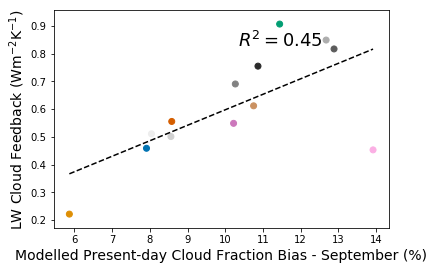

In [282]:
rval2,pval2,lines2,labels2 = plot_correlation_arb2(9,x,exp_corr,colors=corr_palette,legend=True,labels=list(label_dict.values())[:6],linestyle='dashed')


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


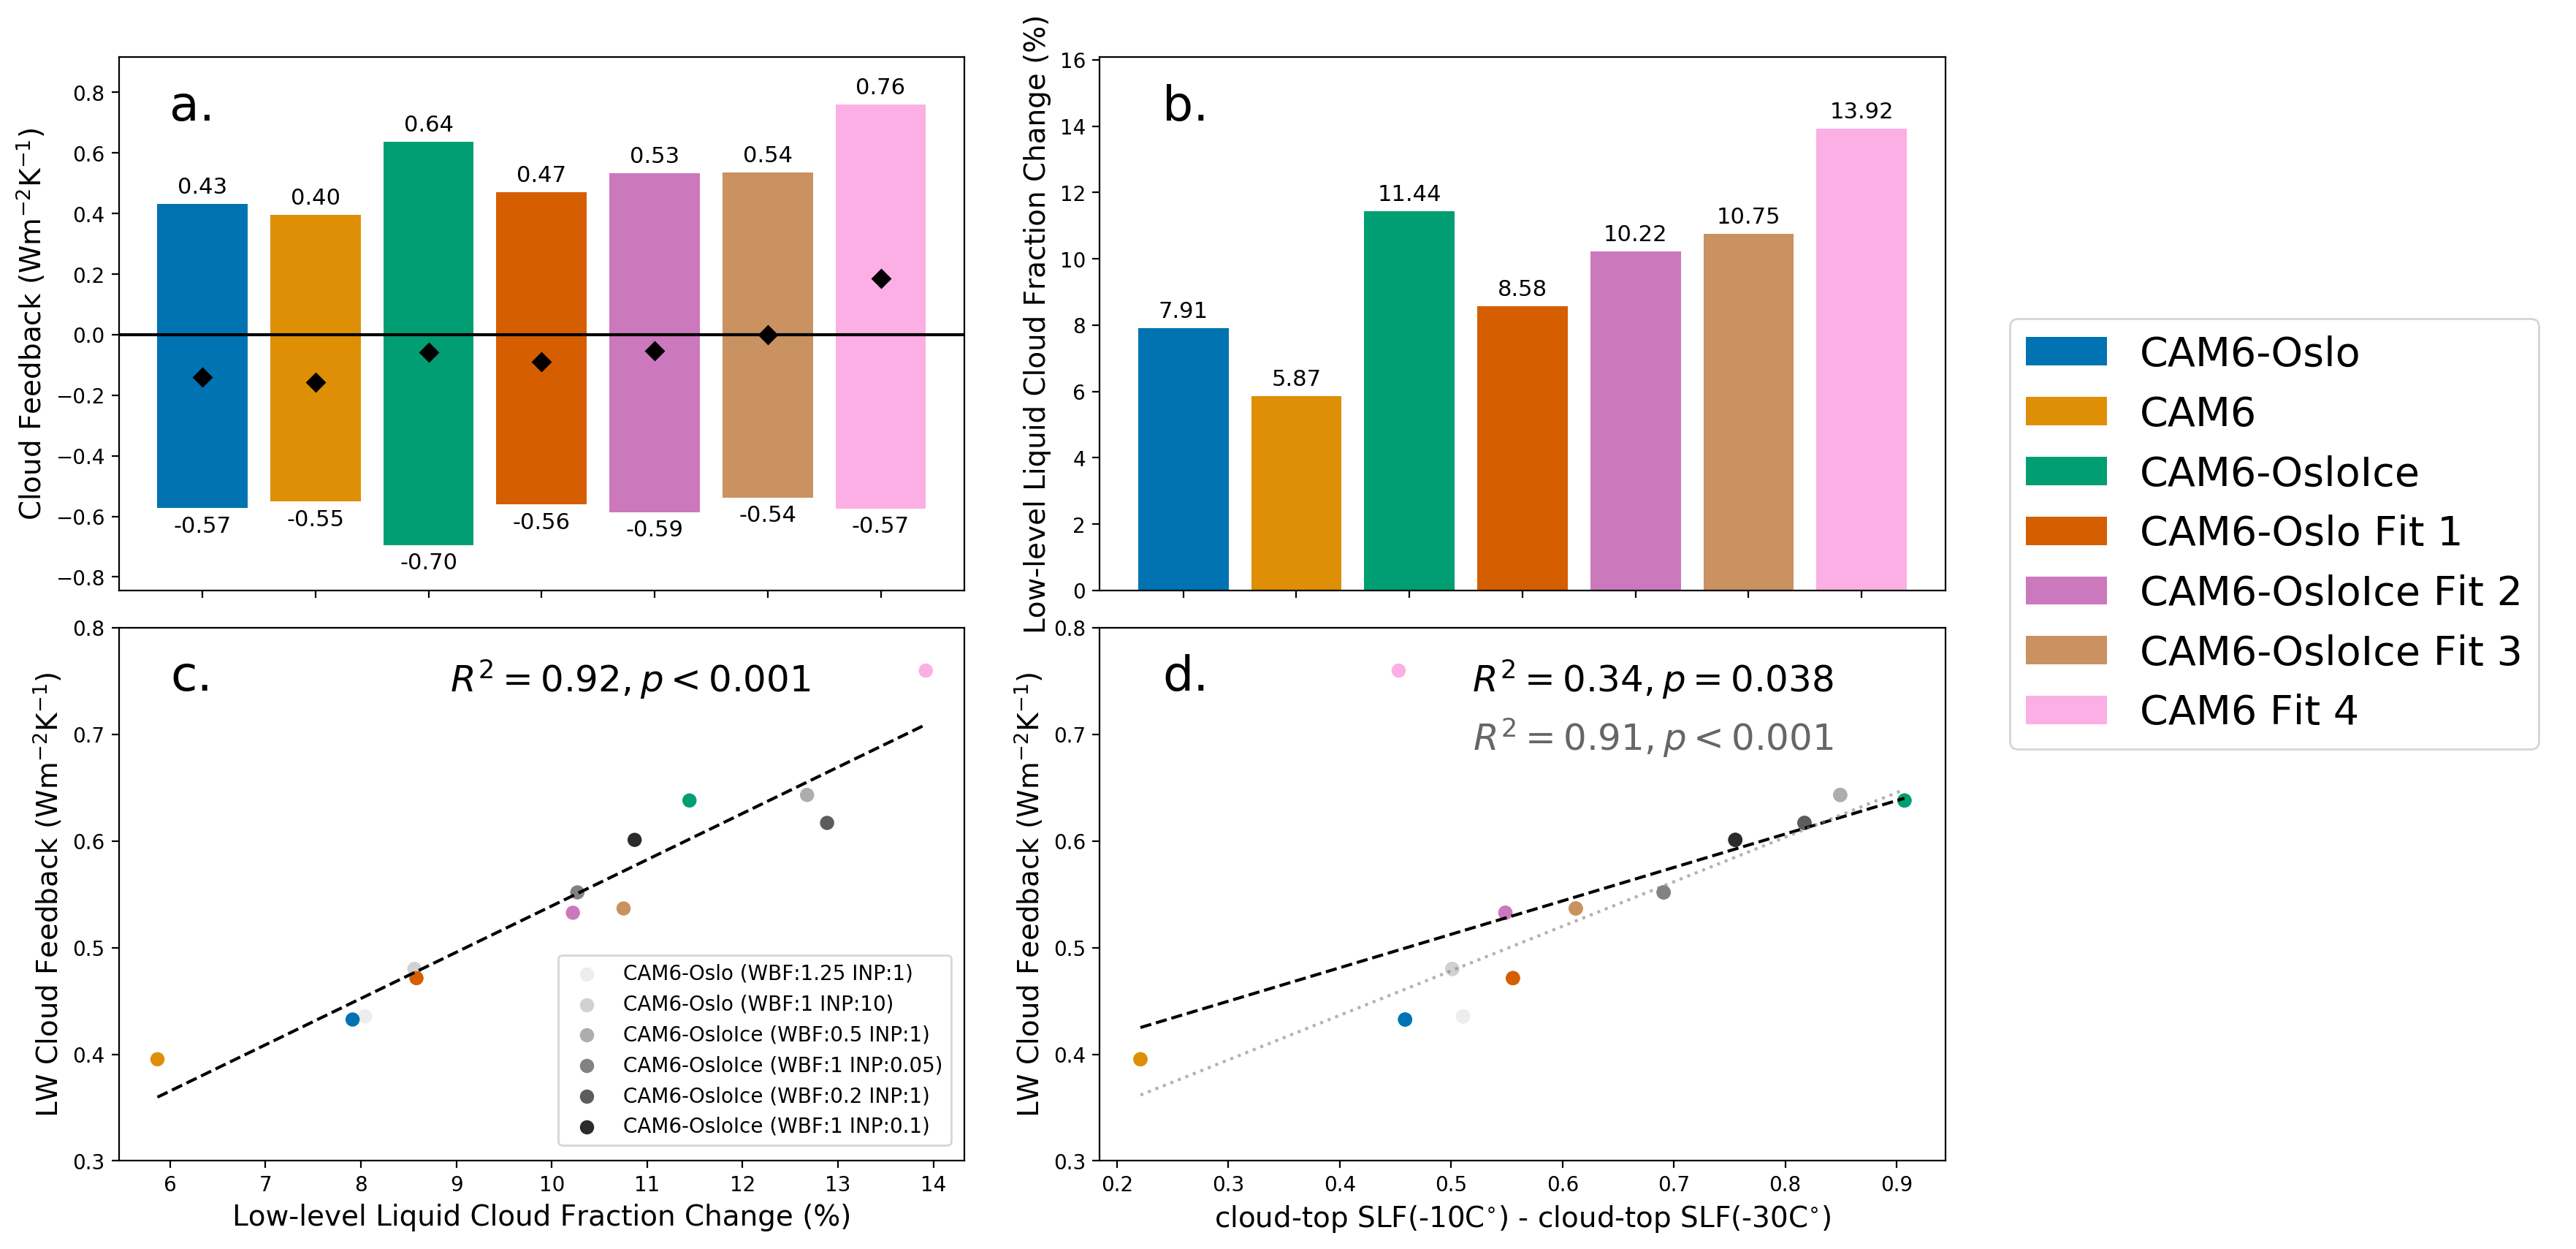

In [280]:
fig,axs = plt.subplots(nrows=2,ncols=2)#,sharey='row')
fig.set_figheight(10)
fig.set_figwidth(20)
fig.set_dpi(200)

axs = axs.flat
fig.subplots_adjust(wspace=0.16,hspace=0.07)

LWfb_plt,LWfb_axes,vals1 = barplot_single(case_dict2c,out2c,'cloudlw_fb',
                                    labels=label_dict_fitted,ax=axs[0])

SWfb_plt,SWfb_axes,vals2 = barplot_single(case_dict2c,out2c,'cloudsw_fb',
                                    labels=label_dict_fitted,ax=axs[0])

# SWfb_plt2,SWfb_axes2,vals3 = barplot_single(case_dict2b,out2,'APRP_SWfb',
#                                     labels=label_dict,ax=axs[0],hatch = r'//') # ,edgecolor='black'

net_vals = {}
net_vals2 = {}
# for i in vals1:
for i in vals1:
    net_vals[i] = vals1[i]+vals2[i]

out_test = axs[0].plot(np.arange(0,len(net_vals)),net_vals.values(),marker='D',color='black',linestyle="")


# Select the 6-month range from November through April
x = select_month_range(11,lowliq_cloud_diff_arcavg,totm=6)
# Process into a dictionary
dC_NovApr_lowliq_dict = {}
for _dC,_key in zip(x,dClowliq_dict.keys()):
    dC_NovApr_lowliq_dict[_key] = _dC

dC_plt,dC_axes,_ = barplot_single(case_dict2c,out2c,'filler',
                                  labels=label_dict_fitted,vals=dC_NovApr_lowliq_dict,ax=axs[1])
#                                   labels=label_dict_fitted,vals=dClowliq_dict,ax=axs[1])
#                                   labels=label_dict_fitted,vals=dC_dict,ax=axs[1])


# Correlate low-level liquid cloud changes Nov.-Apr. with the LW cloud feedback
rval2,pval2,lines2,labels2 = plot_correlation_arb2(9,x,out2['cloudlw_fb'],axs[2],colors=corr_palette,legend=True,labels=list(label_dict.values())[:6],linestyle='dashed')

# exp_corr = np.array(list(test_corr.values()))
exp_corr = np.array(list(d_slf.values()))
rval3,pval3,lines3,labels3 = plot_correlation_arb2(11,exp_corr,out2['cloudlw_fb'],axs[3],colors=corr_palette,legend=True,labels=list(label_dict.values())[:6],linestyle='dashed')
rval_exp,pval_exp,lines_exp,labels_exp = plot_correlation_arb2(11,exp_corr[:-1],out2['cloudlw_fb'][:-1],axs[3],colors=corr_palette,legend=True,labels=list(label_dict.values())[:6],
                                                               color='Grey',alpha=0.6,linestyle='dotted')


# Plot correlation
# rval,stat_string = plot_correlation(11,['cloudlw_fb'],totm=6,ax=axs[3])

# this depends on the order unfortunately
corr_palette = sns.color_palette('Greys') + sns.color_palette('colorblind')[:7] 

# Mute existing labels and draw zero lines
for i,_ax in enumerate(axs):
    mute_ax(_ax)
#     if (i != 3):
    if (i < 2):
        _ax.set_xticklabels([])
        _ax.set_ylim(1.1*np.array(_ax.get_ylim())) # Create space for labels

axs[0].hlines(0,axs[1].get_xlim()[0],axs[1].get_xlim()[1])#, linestyle='dashed',color='gray')
axs[0].set_xlim(axs[1].get_xlim()[0],axs[1].get_xlim()[1])
_ax0max = max(np.absolute(axs[0].get_ylim()))
_ax0min = axs[0].get_ylim()[0]
axs[0].set_ylim(_ax0min,_ax0max)
# axs[0].set_ylim(-1*_ax0max,_ax0max)
axs[0].set_ylabel('Cloud Feedback (Wm$^{-2}$K$^{-1}$)',fontsize=14)

axs[1].set_ylabel('Low-level Liquid Cloud Fraction Change (%)',fontsize=14)

axs[2].set_ylabel('LW Cloud Feedback (Wm$^{-2}$K$^{-1}$)',fontsize=14)
axs[2].set_xlabel('Low-level Liquid Cloud Fraction Change (%)',fontsize=14)
axs[2].set_ylim(0.3,0.8)

axs[3].set_ylabel('LW Cloud Feedback (Wm$^{-2}$K$^{-1}$)',fontsize=14)
axs[3].set_xlabel('cloud-top SLF(-10C$^{\circ}$) - cloud-top SLF(-30C$^{\circ}$)',fontsize=14)
# axs[3].set_xlabel('SLF-derived Feedback Predictor',fontsize=14)
axs[3].set_ylim(0.3,0.8)

# fig.text(0.65, 0.44, '$R^2 = %s, p = 0.038$' % (np.round(out1,2)), va='bottom', ha='center', rotation='horizontal', 
#          rotation_mode='anchor', fontsize=18)
fig.text(0.3, 0.44, '$R^2 = %.2f, p < 0.001$' % (rval2), va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=18)
fig.text(0.65, 0.44, '$R^2 = %.2f, p = %.3f$' % (rval3,pval3), va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=18)
fig.text(0.65, 0.4, '$R^2 = %.2f, p < 0.001$' % (rval_exp), va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=18,alpha=0.6)
fig.text(0.15, 0.83, 'a.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.49, 0.83, 'b.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.15, 0.44, 'c.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.49, 0.44, 'd.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)

labels = []; lines = [] #Plot invisible bar graph but have the legends specified
for _key,_color in zip(case_dict2c,sns.color_palette('colorblind')[:7]):
    labels.append(label_dict[_key])
    _line = axs[0].bar(1,1,width=0,color=_color)
    lines.append(_line)

lgd = fig.legend(labels=labels,handles=lines,loc=(0.78, 0.40),fontsize=20)
axs[2].legend(handles=lines2,labels=labels2,loc=(0.52, 0.03))

fig.subplots_adjust(right=0.75)

In [281]:
to_png(fig,'slffeedback_predictor')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


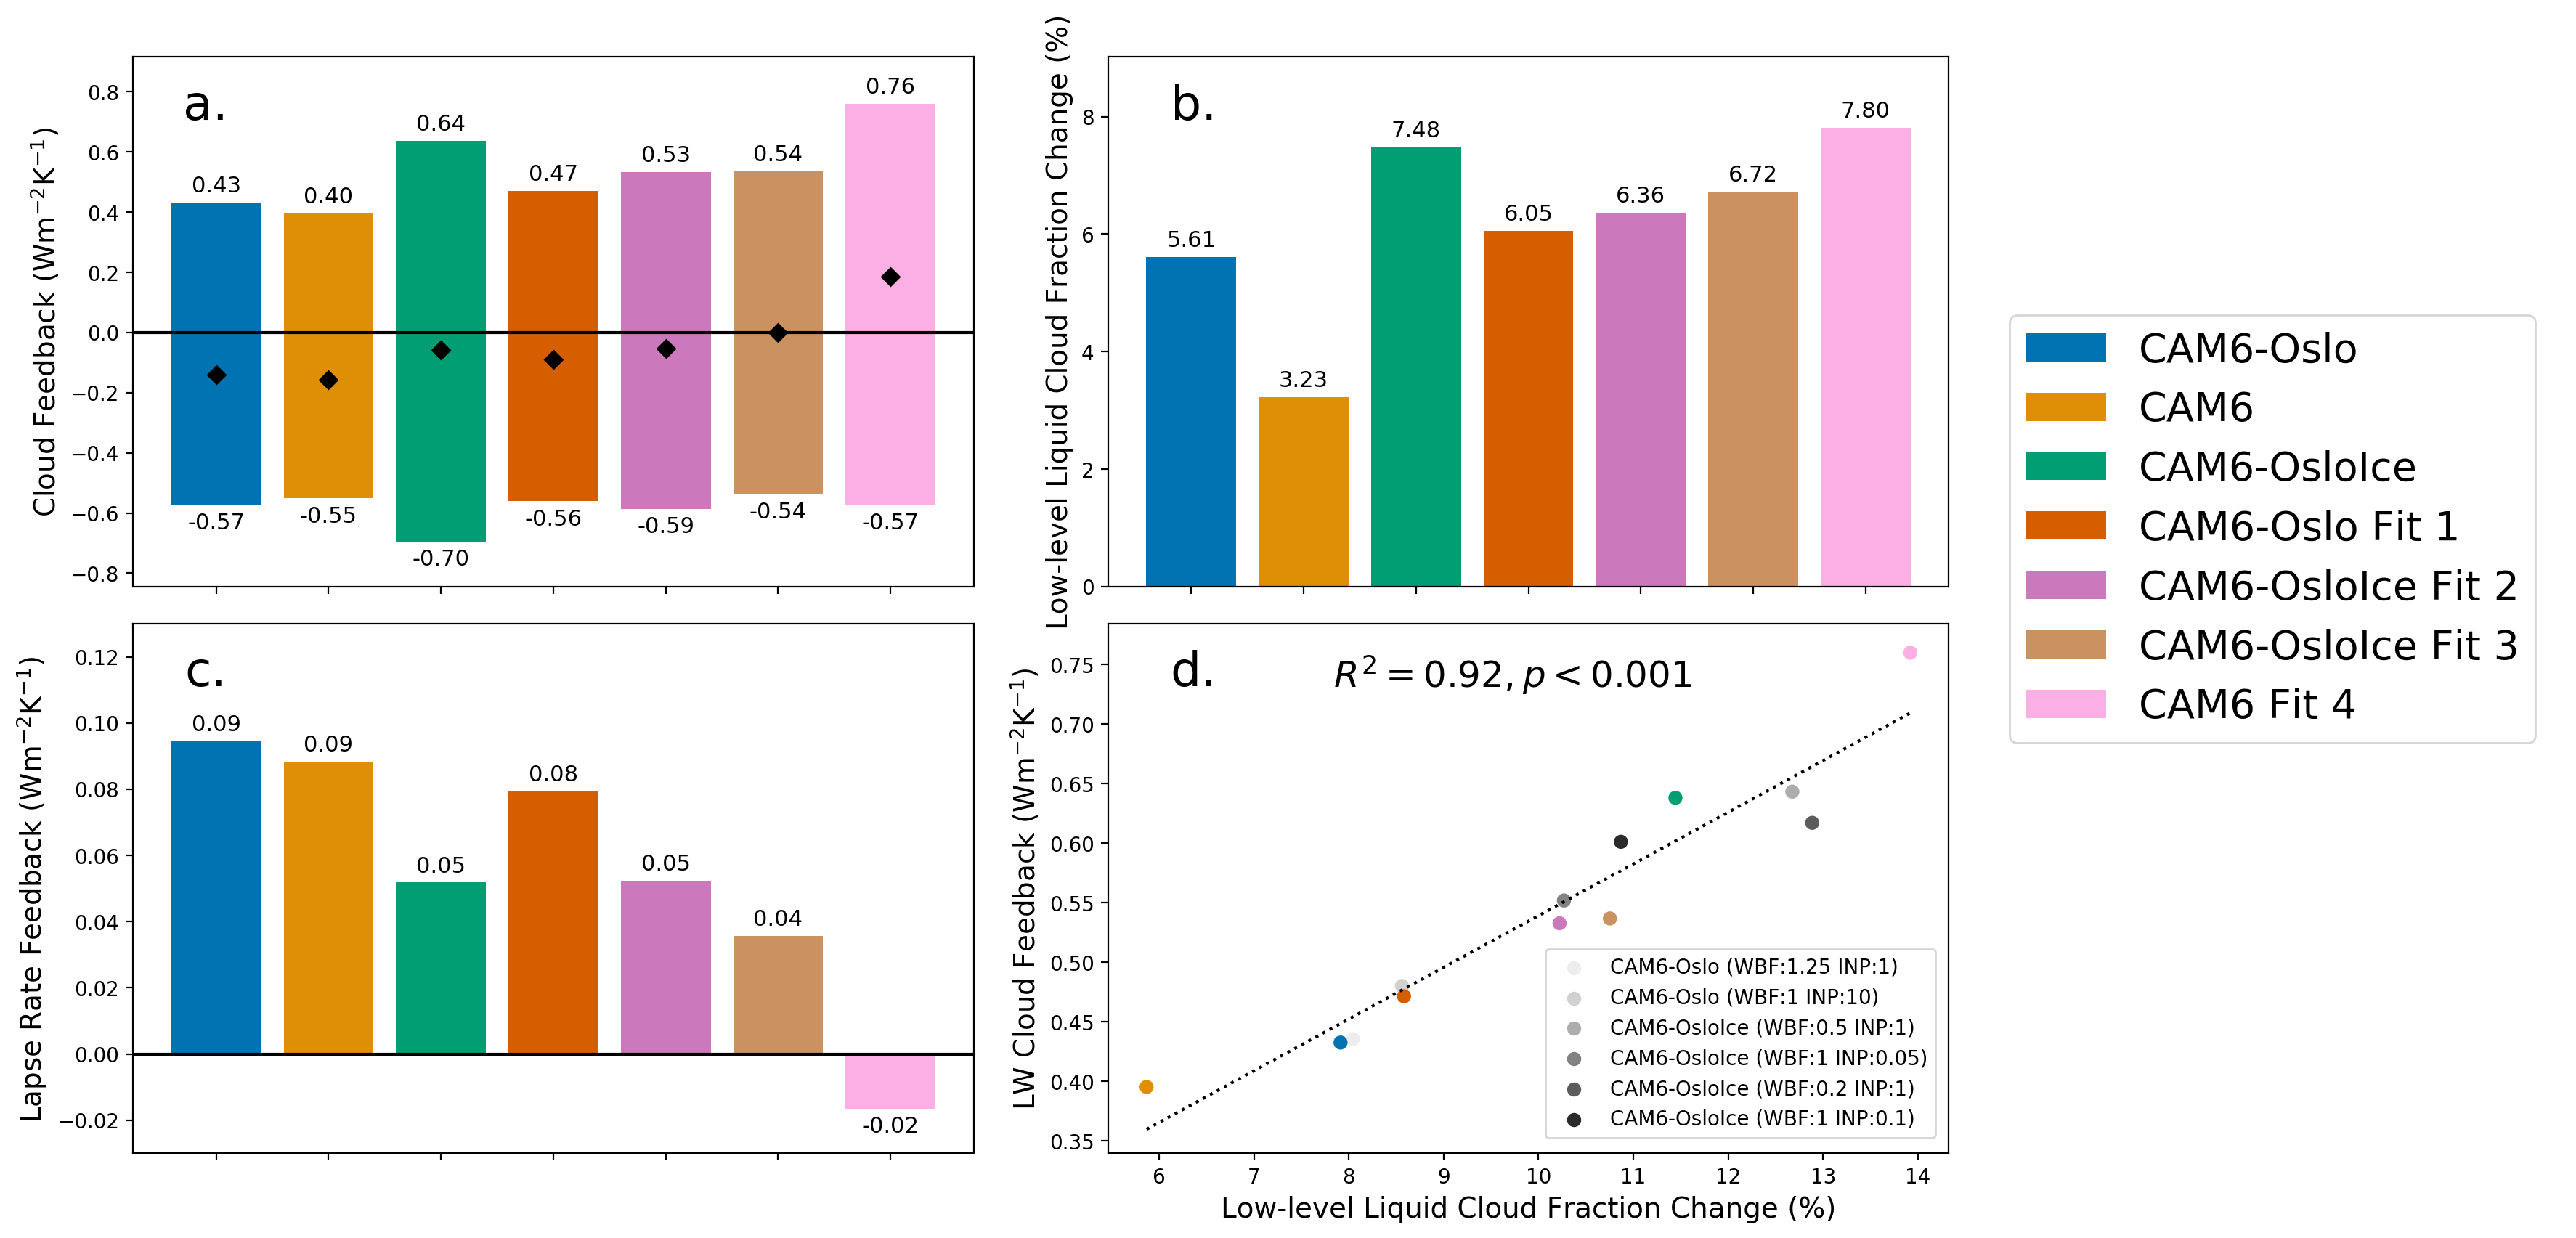

In [268]:
fig,axs = plt.subplots(nrows=2,ncols=2)#,sharey='row')
fig.set_figheight(10)
fig.set_figwidth(20)
fig.set_dpi(200)

axs = axs.flat
fig.subplots_adjust(wspace=0.16,hspace=0.07)

LWfb_plt,LWfb_axes,vals1 = barplot_single(case_dict2c,out2c,'cloudlw_fb',
                                    labels=label_dict_fitted,ax=axs[0])

SWfb_plt,SWfb_axes,vals2 = barplot_single(case_dict2c,out2c,'cloudsw_fb',
                                    labels=label_dict_fitted,ax=axs[0])

# SWfb_plt2,SWfb_axes2,vals3 = barplot_single(case_dict2b,out2,'APRP_SWfb',
#                                     labels=label_dict,ax=axs[0],hatch = r'//') # ,edgecolor='black'

net_vals = {}
net_vals2 = {}
# for i in vals1:
for i in vals1:
    net_vals[i] = vals1[i]+vals2[i]

out_test = axs[0].plot(np.arange(0,len(net_vals)),net_vals.values(),marker='D',color='black',linestyle="")

    
dC_plt,dC_axes,_ = barplot_single(case_dict2c,out2c,'filler',
#                                   labels=label_dict_fitted,vals=dC_NovApr_lowliq_dict,ax=axs[1])
                                  labels=label_dict_fitted,vals=dClowliq_dict,ax=axs[1])
#                                   labels=label_dict_fitted,vals=dC_dict,ax=axs[1])

dT_plt,dT_axes,_ = barplot_single(case_dict2c,out2c,'lapserate_fb',
                                  labels=label_dict_fitted,ax=axs[2])
# dT_plt,dT_axes,_ = barplot_single(case_dict2c,out2c,'filler',
#                                   labels=label_dict_fitted,vals=ts_dict,ax=axs[2])

# Plot correlation
# rval,stat_string = plot_correlation(11,['cloudlw_fb'],totm=6,ax=axs[3])

# this depends on the order unfortunately
corr_palette = sns.color_palette('Greys') + sns.color_palette('colorblind')[:7] 

# x = select_month_range(11,low_cloud_diff_arcavg,totm=6)
# x = select_month_range(11,lowliq_cloud_diff_arcavg,totm=6)
rval,pval,lines3,labels3 = plot_correlation_arb2(11,x,out2['cloudlw_fb'],axs[3],colors=corr_palette,legend=True,labels=list(label_dict.values())[:6])

# Mute existing labels and draw zero lines
for i,_ax in enumerate(axs):
    mute_ax(_ax)
    if i != 3:
        _ax.set_xticklabels([])
        _ax.set_ylim(1.1*np.array(_ax.get_ylim())) # Create space for labels

axs[0].hlines(0,axs[1].get_xlim()[0],axs[1].get_xlim()[1])#, linestyle='dashed',color='gray')
axs[0].set_xlim(axs[1].get_xlim()[0],axs[1].get_xlim()[1])
_ax0max = max(np.absolute(axs[0].get_ylim()))
_ax0min = axs[0].get_ylim()[0]
axs[0].set_ylim(_ax0min,_ax0max)
# axs[0].set_ylim(-1*_ax0max,_ax0max)
axs[0].set_ylabel('Cloud Feedback (Wm$^{-2}$K$^{-1}$)',fontsize=14)

axs[1].set_ylabel('Low-level Liquid Cloud Fraction Change (%)',fontsize=14)
# axs[1].set_yticklabels(['0.0','2.0','4.0','6.0','8.0'])

axs[2].set_ylabel('Lapse Rate Feedback (Wm$^{-2}$K$^{-1}$)',fontsize=14)
axs[2].set_xlim(axs[1].get_xlim()[0],axs[1].get_xlim()[1])
axs[2].hlines(0,axs[1].get_xlim()[0],axs[1].get_xlim()[1])#, linestyle='dashed',color='gray')
axs[2].set_ylim((-0.03,0.13))


axs[3].set_ylabel('LW Cloud Feedback (Wm$^{-2}$K$^{-1}$)',fontsize=14)
axs[3].set_xlabel('Low-level Liquid Cloud Fraction Change (%)',fontsize=14)

# fig.text(0.6, 0.44, '$R^2 = %.2f, p = %.3f$' % (rval,pval), va='bottom', ha='center', rotation='horizontal', 
fig.text(0.6, 0.44, '$R^2 = %.2f, p < 0.001$' % (rval), va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=18)
fig.text(0.15, 0.83, 'a.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.49, 0.83, 'b.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.15, 0.44, 'c.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.49, 0.44, 'd.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)

labels = []; lines = [] #Plot invisible bar graph but have the legends specified
for _key,_color in zip(case_dict2c,sns.color_palette('colorblind')[:7]):
    labels.append(label_dict[_key])
    _line = axs[0].bar(1,1,width=0,color=_color)
    lines.append(_line)

lgd = fig.legend(labels=labels,handles=lines,loc=(0.78, 0.40),fontsize=20)
axs[3].legend(handles=lines3,labels=labels3,loc=(0.52, 0.03))

fig.subplots_adjust(right=0.75)

In [114]:
to_png(fig,"feedback_winter_corr_LR4")

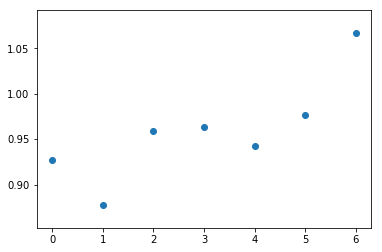

In [215]:
net_fbs = np.zeros(7)

for _fb in out2c: #['lapserate_fb']
    fbs = np.array(out2c[_fb])
    
    net_fbs = net_fbs + fbs
#     for i,_case_fb in enumerate(_fb):
#         net_fbs[i] = net_fbs[i] + _case_fb

fig_test,axs_test = plt.subplots(1,1)

x = np.arange(0,len(net_cloudfb),1)


plt.scatter(x,net_fbs,label='Net Feedback')
# ax = plt.gca()
# ax.set_xticks(list(label_dict_fitted.values()))

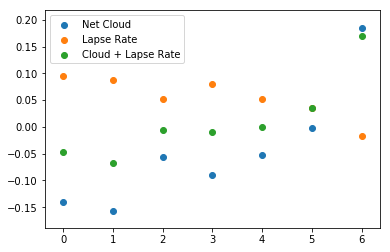

In [187]:
fig_test,axs_test = plt.subplots(1,1)

net_cloudfb = np.array(list(net_vals.values()))

lr_fb = np.array(out2c['lapserate_fb'])

x = np.arange(0,len(net_cloudfb),1)

cloudplusLR_fb = np.array(list(net_vals.values())) + np.array(out2c['lapserate_fb'])

plt.scatter(x,net_cloudfb,label='Net Cloud')
plt.scatter(x,lr_fb,label='Lapse Rate')
plt.scatter(x, cloudplusLR_fb,label='Cloud + Lapse Rate')

plt.legend()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


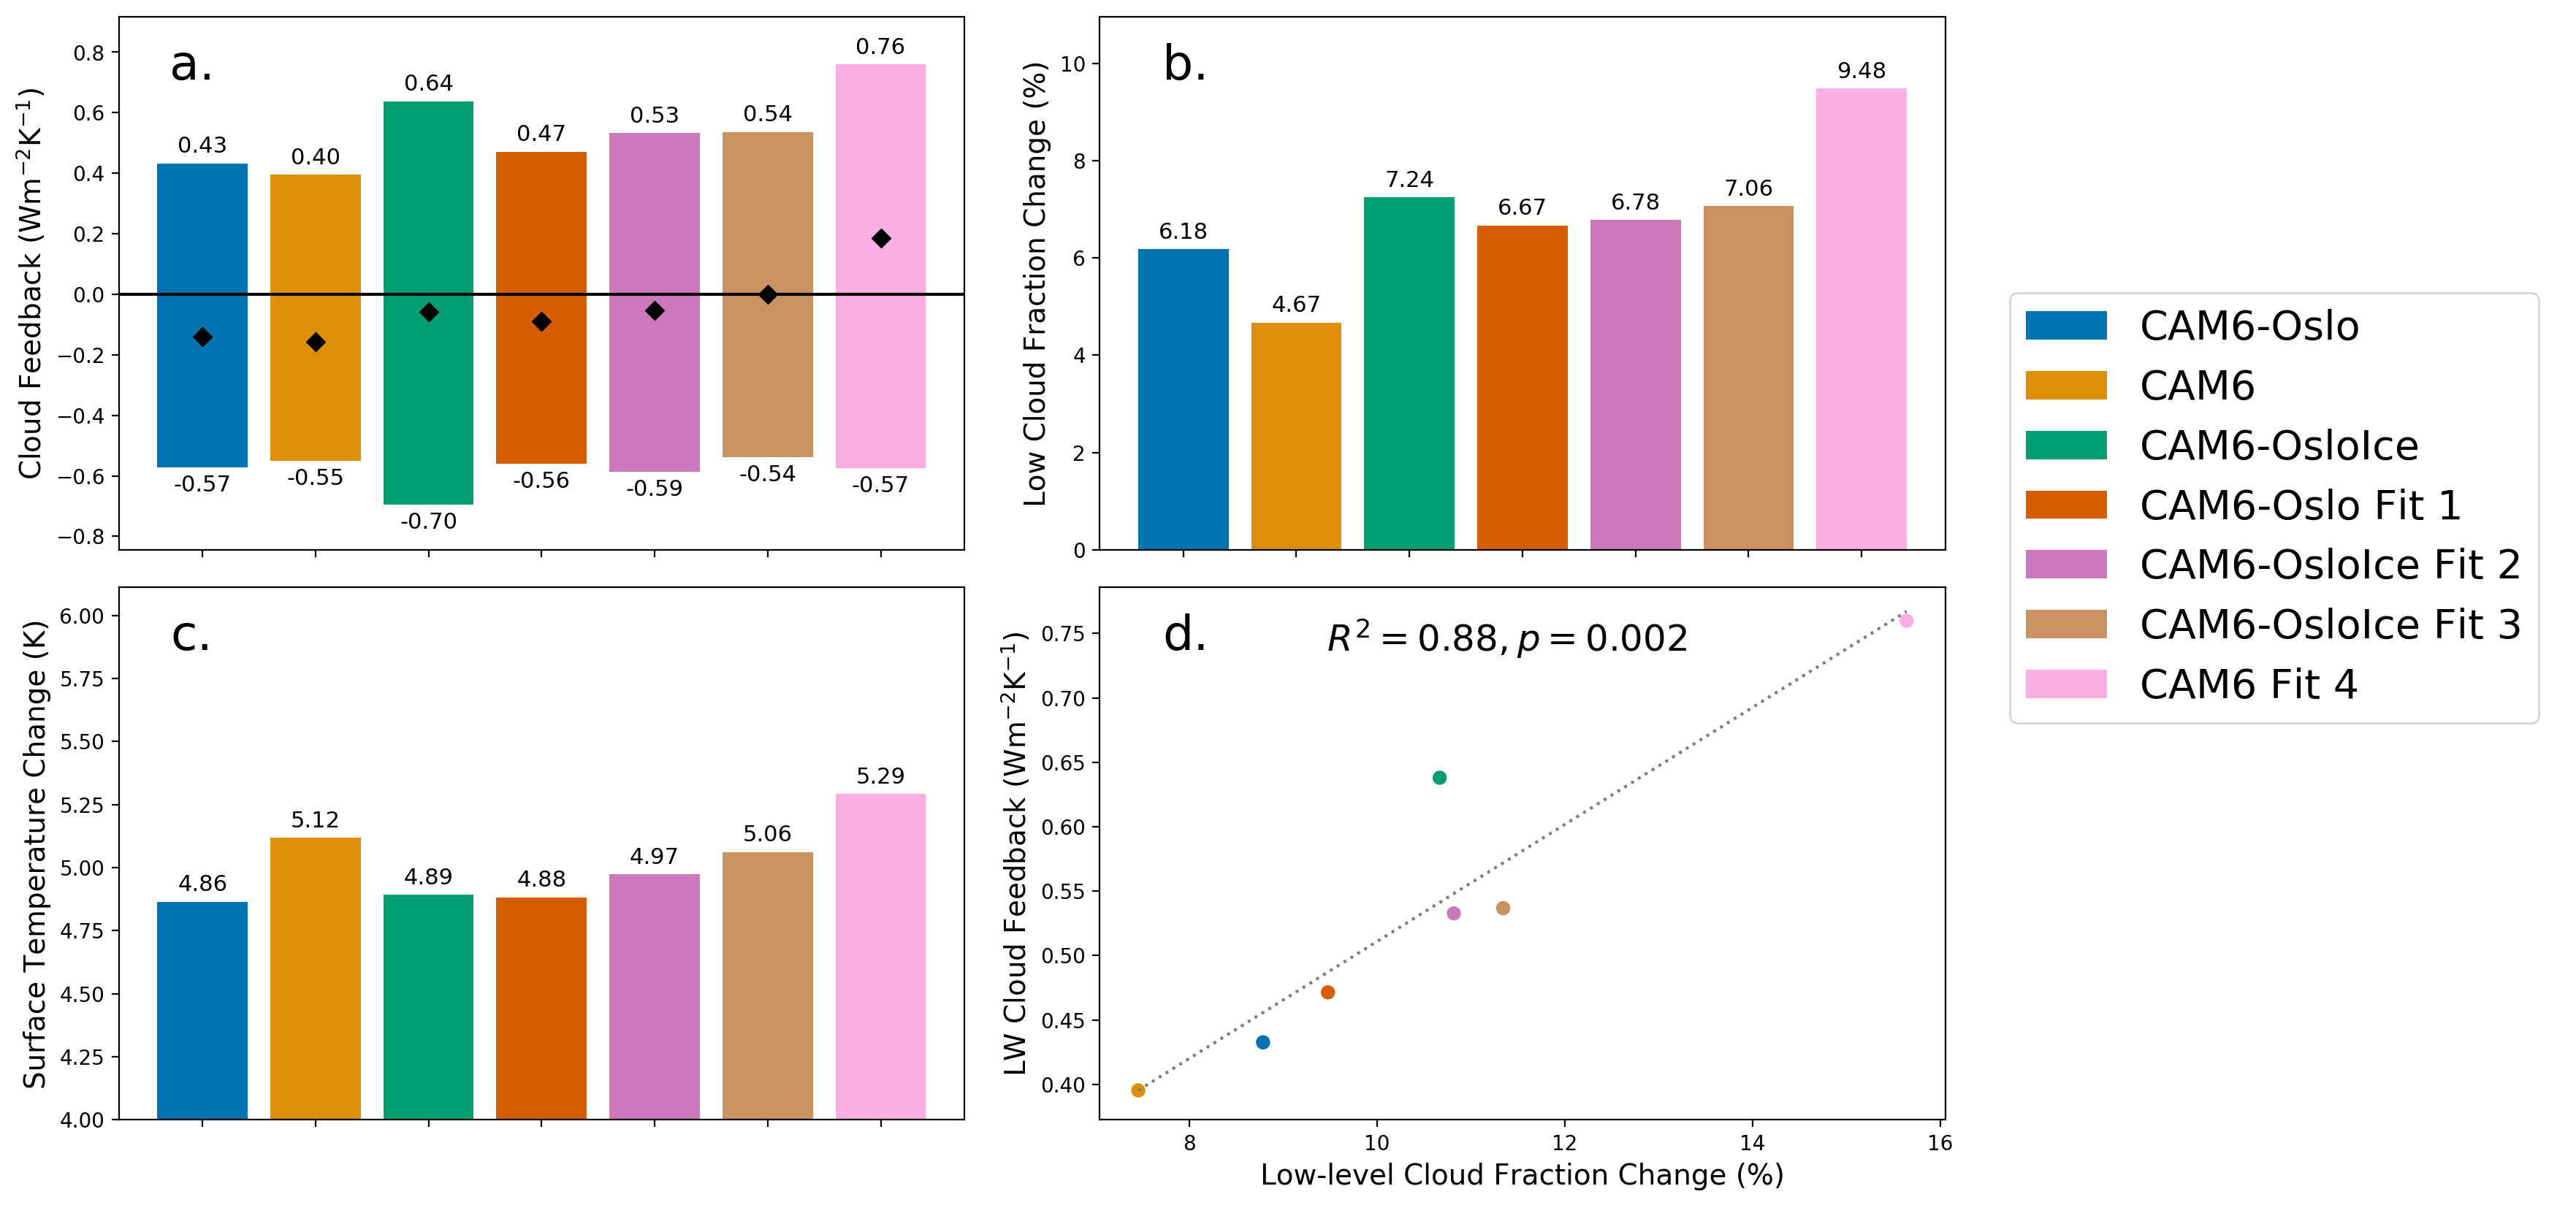

In [115]:
fig,axs = plt.subplots(nrows=2,ncols=2)#,sharey='row')
fig.set_figheight(10)
fig.set_figwidth(20)
fig.set_dpi(200)

axs = axs.flat
fig.subplots_adjust(wspace=0.16,hspace=0.07)

LWfb_plt,LWfb_axes,vals1 = barplot_single(case_dict2b,out2,'cloudlw_fb',
                                    labels=label_dict,ax=axs[0])

SWfb_plt,SWfb_axes,vals2 = barplot_single(case_dict2b,out2,'cloudsw_fb',
                                    labels=label_dict,ax=axs[0])

# SWfb_plt2,SWfb_axes2,vals3 = barplot_single(case_dict2b,out2,'APRP_SWfb',
#                                     labels=label_dict,ax=axs[0],hatch = r'//') # ,edgecolor='black'

net_vals = {}
net_vals2 = {}
# for i in vals1:
for i in vals1:
    net_vals[i] = vals1[i]+vals2[i]
#     net_vals2[i] = vals1[i]+vals3[i]

out_test = axs[0].plot(np.arange(0,7),net_vals.values(),marker='D',color='black',linestyle="")
# out_test2 = axs[0].plot(np.arange(0,7),net_vals2.values(),marker='x',color='black',linestyle="")
# out_test2 = axs[0].plot(np.arange(0,7),out2['APRP_SWfb'],marker='D',color='red',linestyle="")

# autolabel4(out_test[0],axs[0])

dC_plt,dC_axes,_ = barplot_single(case_dict2b,out2,'filler',
                                  labels=label_dict,vals=dC_dict,ax=axs[1])

dT_plt,dT_axes,_ = barplot_single(case_dict2b,out2,'filler',
                                  labels=label_dict,vals=ts_dict,ax=axs[2])

# Plot correlation
# rval,stat_string = plot_correlation(11,['cloudlw_fb'],totm=6,ax=axs[3])

x = select_month_range(11,low_cloud_diff_arcavg,totm=6)

rval,pval = low_cloud_diff_arcavg(11,x,out2['cloudlw_fb'],axs[3])

# Mute existing labels and draw zero lines
for i,_ax in enumerate(axs):
    mute_ax(_ax)
    if i != 3:
        _ax.set_xticklabels([])
        _ax.set_ylim(1.1*np.array(_ax.get_ylim())) # Create space for labels

axs[0].hlines(0,axs[1].get_xlim()[0],axs[1].get_xlim()[1])#, linestyle='dashed',color='gray')
axs[0].set_xlim(axs[1].get_xlim()[0],axs[1].get_xlim()[1])
_ax0max = max(np.absolute(axs[0].get_ylim()))
_ax0min = axs[0].get_ylim()[0]
axs[0].set_ylim(_ax0min,_ax0max)
# axs[0].set_ylim(-1*_ax0max,_ax0max)
axs[0].set_ylabel('Cloud Feedback (Wm$^{-2}$K$^{-1}$)',fontsize=14)

axs[1].set_ylabel('Low Cloud Fraction Change (%)',fontsize=14)

axs[2].set_ylabel('Surface Temperature Change (K)',fontsize=14)
axs[2].set_ylim((4,axs[2].get_ylim()[1]))


axs[3].set_ylabel('LW Cloud Feedback (Wm$^{-2}$K$^{-1}$)',fontsize=14)
axs[3].set_xlabel('Low-level Cloud Fraction Change (%)',fontsize=14)

# fig.text(0.65, 0.44, '$R^2 = %s, p = 0.038$' % (np.round(out1,2)), va='bottom', ha='center', rotation='horizontal', 
#          rotation_mode='anchor', fontsize=18)
fig.text(0.6, 0.44, '$R^2 = %.2f, p = %.3f$' % (rval,pval), va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=18)
fig.text(0.15, 0.83, 'a.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.49, 0.83, 'b.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.15, 0.44, 'c.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.49, 0.44, 'd.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)

labels = []; lines = [] #Plot invisible bar graph but have the legends specified
for _key,_color in zip(case_dict2b,sns.color_palette('colorblind')):
    labels.append(label_dict[_key])
    _line = axs[0].bar(1,1,width=0,color=_color)
    lines.append(_line)

lgd = fig.legend(labels=labels,handles=lines,loc=(0.78, 0.40),fontsize=20)

fig.subplots_adjust(right=0.75)

In [116]:
to_png(fig,'feedback_winter_corr_lowcld')

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


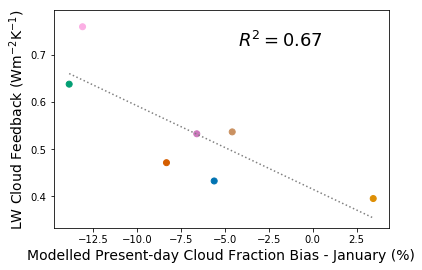

In [23]:
plot_correlation(1,['cloudlw_fb'],totm=3)

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.65,0.74,'$R^2 = 0.86$')

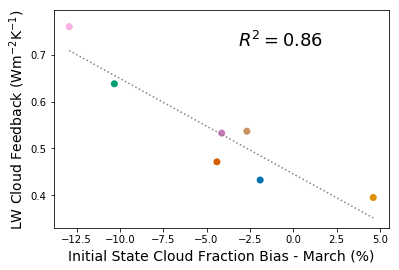

In [126]:
month = 3

month_names = {'1':'January','2':'February','3':'March',
              '4':'April','5':'May','6':'June',
              '7':'July','8':'August','9':'September',
              '10':'October','11':'November','12':'December'}

_,data = get_month(month,allmonth_clouddict)
month_name = month_names[str(month)]

# Do correlation
y = np.array(out2['cloudlw_fb'])
x = np.array(data) - float(arc_mean.sel(month=month))

model = LinearRegression()
model.fit(x.reshape(-1,1), y.reshape(-1,1))
# x_new = np.linspace(min(x), max(x), 100)
x_new = np.linspace(min(x), max(x), 100)
y_new = model.predict(x_new[:, np.newaxis])
y_pred = model.predict(x.reshape(-1,1))
categories = np.array([0, 1, 2, 3, 4, 5, 6, 7])
colormap = np.array(sns.color_palette('colorblind'))

# Plot correlation
fig,axs = plt.subplots(nrows=1,ncols=1)#,sharey='row')
axs.scatter(x, y, c=colormap[categories],marker='o')
axs.plot(x_new,y_new,c='grey',linestyle='dotted')

axs.set_ylabel('LW Cloud Feedback (Wm$^{-2}$K$^{-1}$)',fontsize=14)
axs.set_xlabel('Initial State Cloud Fraction Bias - %s (%%)' % month_name,fontsize=14)

fig.text(0.65, 0.74, '$R^2 = %.2f$' % r2_score(y, y_pred), va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=18)

## Functioning simple versions

NameError: name 'apr_totcloud' is not defined

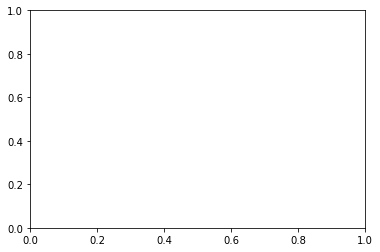

In [121]:
fig,axs = plt.subplots(nrows=1,ncols=1)#,sharey='row')

# Do correlation
y = np.array(out2['cloudlw_fb'])
x = np.array(apr_totcloud) - float(arc_mean.sel(month=4))

model = LinearRegression()
model.fit(x.reshape(-1,1), y.reshape(-1,1))
# x_new = np.linspace(min(x), max(x), 100)
x_new = np.linspace(min(x), 0, 100)
y_new = model.predict(x_new[:, np.newaxis])
y_pred = model.predict(x.reshape(-1,1))
categories = np.array([0, 1, 2, 3, 4, 5, 6, 7])
colormap = np.array(sns.color_palette('colorblind'))

# Plot correlation
axs.scatter(x, y, c=colormap[categories],marker='o')
axs.plot(x_new,y_new,c='grey',linestyle='dotted')

axs.set_ylabel('LW Cloud Feedback (Wm$^{-2}$K$^{-1}$)',fontsize=14)
axs.set_xlabel('Initial State Cloud Fraction Bias - April (%)',fontsize=14)

fig.text(0.65, 0.74, '$R^2 = %.2f$' % r2_score(y, y_pred), va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=18)

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.65,0.74,'$R^2 = 0.25$')

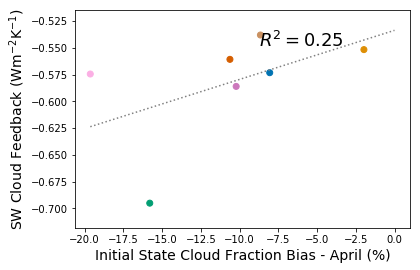

In [29]:
fig,axs = plt.subplots(nrows=1,ncols=1)#,sharey='row')

# Do correlation
y = np.array(out2['cloudsw_fb'])
x = np.array(apr_totcloud) - float(arc_mean.sel(month=4))

model = LinearRegression()
model.fit(x.reshape(-1,1), y.reshape(-1,1))
# x_new = np.linspace(min(x), max(x), 100)
x_new = np.linspace(min(x), 0, 100)
y_new = model.predict(x_new[:, np.newaxis])
y_pred = model.predict(x.reshape(-1,1))
categories = np.array([0, 1, 2, 3, 4, 5, 6, 7])
colormap = np.array(sns.color_palette('colorblind'))

# Plot correlation
axs.scatter(x, y, c=colormap[categories],marker='o')
axs.plot(x_new,y_new,c='grey',linestyle='dotted')

axs.set_ylabel('SW Cloud Feedback (Wm$^{-2}$K$^{-1}$)',fontsize=14)
axs.set_xlabel('Initial State Cloud Fraction Bias - April (%)',fontsize=14)

fig.text(0.65, 0.74, '$R^2 = %.2f$' % r2_score(y, y_pred), va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=18)

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.65,0.74,'$R^2 = 0.65$')

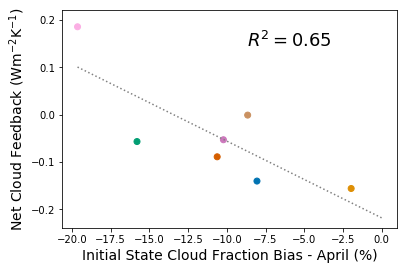

In [34]:
fig,axs = plt.subplots(nrows=1,ncols=1)#,sharey='row')

# Do correlation
y = np.array(np.array(out2['cloudsw_fb']) + np.array(out2['cloudlw_fb']))
x = np.array(apr_totcloud) - float(arc_mean.sel(month=4))

model = LinearRegression()
model.fit(x.reshape(-1,1), y.reshape(-1,1))
# x_new = np.linspace(min(x), max(x), 100)
x_new = np.linspace(min(x), 0, 100)
y_new = model.predict(x_new[:, np.newaxis])
y_pred = model.predict(x.reshape(-1,1))
categories = np.array([0, 1, 2, 3, 4, 5, 6, 7])
colormap = np.array(sns.color_palette('colorblind'))

# Plot correlation
axs.scatter(x, y, c=colormap[categories],marker='o')
axs.plot(x_new,y_new,c='grey',linestyle='dotted')

axs.set_ylabel('Net Cloud Feedback (Wm$^{-2}$K$^{-1}$)',fontsize=14)
axs.set_xlabel('Initial State Cloud Fraction Bias - April (%)',fontsize=14)

fig.text(0.65, 0.74, '$R^2 = %.2f$' % r2_score(y, y_pred), va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=18)